In [39]:
import pandas as pd

test_df = pd.read_csv('test.csv', nrows=1)

In [4]:
import pandas as pd

sub_df = pd.read_csv('sample_submission.csv', nrows=1, index_col=0)
sub_df.head()

ptend_t_0  ptend_t_1  ptend_t_2  ptend_t_3  ptend_t_4  ptend_t_5  \
sample_id                                                                     
test_0             1          1          1          1          1          1   

           ptend_t_6  ptend_t_7  ptend_t_8  ptend_t_9  ...  ptend_v_58  \
sample_id                                              ...               
test_0             1          1          1          1  ...           1   

           ptend_v_59  cam_out_NETSW  cam_out_FLWDS  cam_out_PRECSC  \
sample_id                                                             
test_0              1              1              1               1   

           cam_out_PRECC  cam_out_SOLS  cam_out_SOLL  cam_out_SOLSD  \
sample_id                                                             
test_0                 1             1             1              1   

           cam_out_SOLLD  
sample_id                 
test_0                 1  

[1 rows x 368 columns]

In [19]:
import numpy as np
np.save("scale_output_weights_new.npy", sub_df.values[0])

In [22]:
np.load("scale_output_weights_new.npy")

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [10]:
import numpy as np
import jax.numpy as jnp

x_denorm_mean = np.load("x_denorm_mean.npy")
x_denorm_std = np.load("x_denorm_std.npy")
y_denorm_mean = np.load("y_denorm_mean.npy")
y_denorm_std = np.load("y_denorm_std.npy")

x_denorm_mean_high_res = np.load("x_denorm_mean_high_res.npy")
x_denorm_std_high_res = np.load("x_denorm_std_high_res.npy")
y_denorm_mean_high_res = np.load("y_denorm_mean_high_res.npy")
y_denorm_std_high_res = np.load("y_denorm_std_high_res.npy")

scale_output_weights = np.load("scale_output_weights.npy")
scale_output_weights_high_res = np.load("scale_output_weights_high_res.npy")
not_ablated_col_indices = np.load("not_ablated_col_indices.npy")

def expand_add_ablated_cols(y):
    B = y.shape[0]
    placeholder = jnp.zeros((B, 368))
    placeholder = placeholder.at[:, not_ablated_col_indices].set(
        y, indices_are_sorted=True, unique_indices=True
    )
    return placeholder

def denorm_output(y):
    std = y_denorm_std_high_res if y.shape[1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[1] == 368 else y_denorm_mean 
    y = y * std + mean
    return y

def denorm_and_scale_output(y):
    std = y_denorm_std_high_res if y.shape[1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[1] == 368 else y_denorm_mean
    scale_w = scale_output_weights_high_res if y.shape[1] == 368 else scale_output_weights
    y = y * std + mean
    y = y * scale_w
    return y

def denorm_input(x):
    std = x_denorm_std_high_res if x.shape[1] == 556 else x_denorm_std
    mean = x_denorm_mean_high_res if x.shape[1] == 556 else x_denorm_mean
    x = x * std + mean
    return x

def denorm_scale_and_expand_output(y):
    y = denorm_and_scale_output(y)
    y = expand_add_ablated_cols(y)
    return y

In [27]:
from climsim import climsim_high_res_train
import tensorflow_datasets as tfds

read_config = tfds.ReadConfig(
      shuffle_seed=0,
      override_buffer_size=128,
  )

hr_ds, hr_ds_info = tfds.load(
    "climsim_high_res_train/0",
    data_dir="gs://us2-climsim",
    split="train[:.1%]",
    download=False,
    read_config=read_config,
    shuffle_files=True,
    with_info=True,
)

lr_ds, lr_ds_info = tfds.load(
    "climsim_low_res_train",
    data_dir="gs://us2-climsim",
    split="train[:.1%]",
    read_config=read_config,
    shuffle_files=True,
    with_info=True,
)

lr_ds = lr_ds.batch(1)
hr_ds = hr_ds.batch(1)

for l_data, h_data in zip(lr_ds.take(1), hr_ds.take(1)):
    lx, ly = l_data['inputs'], l_data['targets']
    hx, hy = h_data['inputs'], h_data['targets']
    print(lx.shape, ly.shape, hx.shape, hy.shape)

DatasetNotFoundError: Dataset climsim_low_res_train not found.
Available datasets:
	- abstract_reasoning
	- accentdb
	- aeslc
	- aflw2k3d
	- ag_news_subset
	- ai2_arc
	- ai2_arc_with_ir
	- amazon_us_reviews
	- anli
	- answer_equivalence
	- arc
	- asqa
	- asset
	- assin2
	- asu_table_top_converted_externally_to_rlds
	- austin_buds_dataset_converted_externally_to_rlds
	- austin_sailor_dataset_converted_externally_to_rlds
	- austin_sirius_dataset_converted_externally_to_rlds
	- bair_robot_pushing_small
	- bc_z
	- bccd
	- beans
	- bee_dataset
	- beir
	- berkeley_autolab_ur5
	- berkeley_cable_routing
	- berkeley_fanuc_manipulation
	- berkeley_gnm_cory_hall
	- berkeley_gnm_recon
	- berkeley_gnm_sac_son
	- berkeley_mvp_converted_externally_to_rlds
	- berkeley_rpt_converted_externally_to_rlds
	- big_patent
	- bigearthnet
	- billsum
	- binarized_mnist
	- binary_alpha_digits
	- ble_wind_field
	- blimp
	- booksum
	- bool_q
	- bot_adversarial_dialogue
	- bridge
	- bucc
	- c4
	- c4_wsrs
	- caltech101
	- caltech_birds2010
	- caltech_birds2011
	- cardiotox
	- cars196
	- cassava
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- cfq
	- cherry_blossoms
	- chexpert
	- cifar10
	- cifar100
	- cifar100_n
	- cifar10_1
	- cifar10_corrupted
	- cifar10_h
	- cifar10_n
	- citrus_leaves
	- cityscapes
	- civil_comments
	- clevr
	- clic
	- clinc_oos
	- cmaterdb
	- cmu_franka_exploration_dataset_converted_externally_to_rlds
	- cmu_play_fusion
	- cmu_stretch
	- cnn_dailymail
	- coco
	- coco_captions
	- coil100
	- colorectal_histology
	- colorectal_histology_large
	- columbia_cairlab_pusht_real
	- common_voice
	- conll2002
	- conll2003
	- controlled_noisy_web_labels
	- coqa
	- corr2cause
	- cos_e
	- cosmos_qa
	- covid19
	- covid19sum
	- crema_d
	- criteo
	- cs_restaurants
	- curated_breast_imaging_ddsm
	- cycle_gan
	- d4rl_adroit_door
	- d4rl_adroit_hammer
	- d4rl_adroit_pen
	- d4rl_adroit_relocate
	- d4rl_antmaze
	- d4rl_mujoco_ant
	- d4rl_mujoco_halfcheetah
	- d4rl_mujoco_hopper
	- d4rl_mujoco_walker2d
	- dart
	- databricks_dolly
	- davis
	- deep1b
	- deep_weeds
	- definite_pronoun_resolution
	- dementiabank
	- diabetic_retinopathy_detection
	- diamonds
	- div2k
	- dlr_edan_shared_control_converted_externally_to_rlds
	- dlr_sara_grid_clamp_converted_externally_to_rlds
	- dlr_sara_pour_converted_externally_to_rlds
	- dmlab
	- doc_nli
	- dolphin_number_word
	- domainnet
	- downsampled_imagenet
	- drop
	- dsprites
	- dtd
	- duke_ultrasound
	- e2e_cleaned
	- efron_morris75
	- emnist
	- eraser_multi_rc
	- esnli
	- eth_agent_affordances
	- eurosat
	- fashion_mnist
	- flic
	- flores
	- food101
	- forest_fires
	- fractal20220817_data
	- fuss
	- gap
	- geirhos_conflict_stimuli
	- gem
	- genomics_ood
	- german_credit_numeric
	- gigaword
	- glove100_angular
	- glue
	- goemotions
	- gov_report
	- gpt3
	- gref
	- groove
	- grounded_scan
	- gsm8k
	- gtzan
	- gtzan_music_speech
	- hellaswag
	- higgs
	- hillstrom
	- horses_or_humans
	- howell
	- i_naturalist2017
	- i_naturalist2018
	- i_naturalist2021
	- iamlab_cmu_pickup_insert_converted_externally_to_rlds
	- imagenet2012
	- imagenet2012_corrupted
	- imagenet2012_fewshot
	- imagenet2012_multilabel
	- imagenet2012_real
	- imagenet2012_subset
	- imagenet_a
	- imagenet_lt
	- imagenet_pi
	- imagenet_r
	- imagenet_resized
	- imagenet_sketch
	- imagenet_v2
	- imagenette
	- imagewang
	- imdb_reviews
	- imperialcollege_sawyer_wrist_cam
	- irc_disentanglement
	- iris
	- istella
	- jaco_play
	- kaist_nonprehensile_converted_externally_to_rlds
	- kddcup99
	- kitti
	- kmnist
	- kuka
	- laion400m
	- lambada
	- lfw
	- librispeech
	- librispeech_lm
	- libritts
	- ljspeech
	- lm1b
	- locomotion
	- lost_and_found
	- lsun
	- lvis
	- malaria
	- maniskill_dataset_converted_externally_to_rlds
	- math_dataset
	- math_qa
	- mctaco
	- media_sum
	- mlqa
	- mnist
	- mnist_corrupted
	- movie_lens
	- movie_rationales
	- movielens
	- moving_mnist
	- mrqa
	- mslr_web
	- mt_opt
	- mtnt
	- multi_news
	- multi_nli
	- multi_nli_mismatch
	- natural_instructions
	- natural_questions
	- natural_questions_open
	- newsroom
	- nsynth
	- nyu_depth_v2
	- nyu_door_opening_surprising_effectiveness
	- nyu_franka_play_dataset_converted_externally_to_rlds
	- nyu_rot_dataset_converted_externally_to_rlds
	- ogbg_molpcba
	- omniglot
	- open_images_challenge2019_detection
	- open_images_v4
	- openbookqa
	- opinion_abstracts
	- opinosis
	- opus
	- oxford_flowers102
	- oxford_iiit_pet
	- para_crawl
	- pass
	- patch_camelyon
	- paws_wiki
	- paws_x_wiki
	- penguins
	- pet_finder
	- pg19
	- piqa
	- places365_small
	- placesfull
	- plant_leaves
	- plant_village
	- plantae_k
	- protein_net
	- q_re_cc
	- qa4mre
	- qasc
	- quac
	- quality
	- quickdraw_bitmap
	- race
	- radon
	- real_toxicity_prompts
	- reddit
	- reddit_disentanglement
	- reddit_tifu
	- ref_coco
	- resisc45
	- rlu_atari
	- rlu_atari_checkpoints
	- rlu_atari_checkpoints_ordered
	- rlu_control_suite
	- rlu_dmlab_explore_object_rewards_few
	- rlu_dmlab_explore_object_rewards_many
	- rlu_dmlab_rooms_select_nonmatching_object
	- rlu_dmlab_rooms_watermaze
	- rlu_dmlab_seekavoid_arena01
	- rlu_locomotion
	- rlu_rwrl
	- robomimic_mg
	- robomimic_mh
	- robomimic_ph
	- robonet
	- robosuite_panda_pick_place_can
	- roboturk
	- rock_paper_scissors
	- rock_you
	- s3o4d
	- salient_span_wikipedia
	- samsum
	- savee
	- scan
	- scene_parse150
	- schema_guided_dialogue
	- sci_tail
	- scicite
	- scientific_papers
	- scrolls
	- segment_anything
	- sentiment140
	- shapes3d
	- sift1m
	- simpte
	- siscore
	- smallnorb
	- smartwatch_gestures
	- snli
	- so2sat
	- speech_commands
	- spoken_digit
	- squad
	- squad_question_generation
	- stanford_dogs
	- stanford_hydra_dataset_converted_externally_to_rlds
	- stanford_kuka_multimodal_dataset_converted_externally_to_rlds
	- stanford_mask_vit_converted_externally_to_rlds
	- stanford_online_products
	- stanford_robocook_converted_externally_to_rlds
	- star_cfq
	- starcraft_video
	- stl10
	- story_cloze
	- summscreen
	- sun397
	- super_glue
	- svhn_cropped
	- symmetric_solids
	- taco_play
	- tao
	- tatoeba
	- ted_hrlr_translate
	- ted_multi_translate
	- tedlium
	- tf_flowers
	- the300w_lp
	- tiny_shakespeare
	- titanic
	- tokyo_u_lsmo_converted_externally_to_rlds
	- toto
	- trec
	- trivia_qa
	- tydi_qa
	- uc_merced
	- ucf101
	- ucsd_kitchen_dataset_converted_externally_to_rlds
	- ucsd_pick_and_place_dataset_converted_externally_to_rlds
	- uiuc_d3field
	- unified_qa
	- universal_dependencies
	- unnatural_instructions
	- usc_cloth_sim_converted_externally_to_rlds
	- user_libri_audio
	- user_libri_text
	- utaustin_mutex
	- utokyo_pr2_opening_fridge_converted_externally_to_rlds
	- utokyo_pr2_tabletop_manipulation_converted_externally_to_rlds
	- utokyo_saytap_converted_externally_to_rlds
	- utokyo_xarm_bimanual_converted_externally_to_rlds
	- utokyo_xarm_pick_and_place_converted_externally_to_rlds
	- vctk
	- viola
	- visual_domain_decathlon
	- voc
	- voxceleb
	- voxforge
	- waymo_open_dataset
	- web_graph
	- web_nlg
	- web_questions
	- webvid
	- wider_face
	- wiki40b
	- wiki_auto
	- wiki_bio
	- wiki_dialog
	- wiki_table_questions
	- wiki_table_text
	- wikiann
	- wikihow
	- wikipedia
	- wikipedia_toxicity_subtypes
	- wine_quality
	- winogrande
	- wit
	- wit_kaggle
	- wmt13_translate
	- wmt14_translate
	- wmt15_translate
	- wmt16_translate
	- wmt17_translate
	- wmt18_translate
	- wmt19_translate
	- wmt_t2t_translate
	- wmt_translate
	- wordnet
	- wsc273
	- xnli
	- xquad
	- xsum
	- xtreme_pawsx
	- xtreme_pos
	- xtreme_s
	- xtreme_xnli
	- yahoo_ltrc
	- yelp_polarity_reviews
	- yes_no
	- youtube_vis

Check that:
    - if dataset was added recently, it may only be available
      in `tfds-nightly`
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - the module defining the dataset class is imported

The builder directory gs:/us2-climsim/climsim_low_res_train doesn't contain any versions.
No builder could be found in the directory: gs://us2-climsim for the builder: climsim_low_res_train.
No registered data_dirs were found in:
	- gs://us2-climsim


In [4]:
lxd = denorm_input(lx)
hxd = denorm_input(hx)

NameError: name 'lx' is not defined

In [24]:
USELESS_FEATURES = [
    "pbuf_CH4_27",
    "pbuf_CH4_28",
    "pbuf_CH4_29",
    "pbuf_CH4_30",
    "pbuf_CH4_31",
    "pbuf_CH4_32",
    "pbuf_CH4_33",
    "pbuf_CH4_34",
    "pbuf_CH4_35",
    "pbuf_CH4_36",
    "pbuf_CH4_37",
    "pbuf_CH4_38",
    "pbuf_CH4_39",
    "pbuf_CH4_40",
    "pbuf_CH4_41",
    "pbuf_CH4_42",
    "pbuf_CH4_43",
    "pbuf_CH4_44",
    "pbuf_CH4_45",
    "pbuf_CH4_46",
    "pbuf_CH4_47",
    "pbuf_CH4_48",
    "pbuf_CH4_49",
    "pbuf_CH4_50",
    "pbuf_CH4_51",
    "pbuf_CH4_52",
    "pbuf_CH4_53",
    "pbuf_CH4_54",
    "pbuf_CH4_55",
    "pbuf_CH4_56",
    "pbuf_CH4_57",
    "pbuf_CH4_58",
    "pbuf_CH4_59",
    "pbuf_N2O_27",
    "pbuf_N2O_28",
    "pbuf_N2O_29",
    "pbuf_N2O_30",
    "pbuf_N2O_31",
    "pbuf_N2O_32",
    "pbuf_N2O_33",
    "pbuf_N2O_34",
    "pbuf_N2O_35",
    "pbuf_N2O_36",
    "pbuf_N2O_37",
    "pbuf_N2O_38",
    "pbuf_N2O_39",
    "pbuf_N2O_40",
    "pbuf_N2O_41",
    "pbuf_N2O_42",
    "pbuf_N2O_43",
    "pbuf_N2O_44",
    "pbuf_N2O_45",
    "pbuf_N2O_46",
    "pbuf_N2O_47",
    "pbuf_N2O_48",
    "pbuf_N2O_49",
    "pbuf_N2O_50",
    "pbuf_N2O_51",
    "pbuf_N2O_52",
    "pbuf_N2O_53",
    "pbuf_N2O_54",
    "pbuf_N2O_55",
    "pbuf_N2O_56",
    "pbuf_N2O_57",
    "pbuf_N2O_58",
    "pbuf_N2O_59",
]

all_features = list(test_df.columns[1:])
# np.save("all_features.npy", all_features)

useless_features_indices = [all_features.index(f) for f in USELESS_FEATURES]
# np.save("useless_features_indices.npy", useless_features_indices)
not_useless_features_indices = [i for i in range(len(all_features)) if i not in useless_features_indices]
# np.save("not_useless_features_indices.npy", not_useless_features_indices)
not_useless_features_indices, useless_features_indices

[463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555]

In [15]:
train_stats_df = pd.read_csv("climsim/climsim_high_res_train/train_stats.csv", index_col=0)

state_t_0       state_t_1       state_t_2       state_t_3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       215.170996      227.448849      237.183836      247.999570   
std          7.083899        8.781638        8.387459        6.968301   
min        154.619922      139.066952      168.246148      203.463584   
25%        210.958564      221.737519      231.615478      243.717104   
50%        215.211379      227.692148      236.503888      247.190550   
75%        219.283362      233.544442      242.062411      251.264028   
max        427.707429      313.808117      289.949010      308.059866   

            state_t_4       state_t_5       state_t_6       state_t_7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       256.542024      259.751268      255.567898      247.047336   
std          5.914274        7.473869        9.366398        9.490694   
min        218.180164      213.326016      207.237936      199.187427   
25%        253.147004      256.624740      252.214185      244.289205   
50%        256.085986      260.401241      257.243371      248.936780   
75%        259.522684      263.945913      261.208523      252.550425   
max        309.992211      293.582766      289.413683      282.063814   

            state_t_8       state_t_9  ...    ptend_v_58    ptend_v_59  \
count  1000000.000000  1000000.000000  ...  1.000000e+06  1.000000e+06   
mean       237.427984      230.723525  ...  1.645321e-06  1.486610e-06   
std          8.873518        8.677993  ...  2.489970e-05  3.582885e-05   
min        190.697156      183.891891  ... -4.052040e-04 -7.709305e-04   
25%        235.369310      229.047113  ... -6.571661e-06 -8.182056e-06   
50%        239.464336      233.048222  ... -1.392022e-10  5.497077e-07   
75%        242.337102      235.460049  ...  8.147949e-06  1.284909e-05   
max        273.351677      266.611876  ...  3.981657e-04  6.144464e-04   

        cam_out_NETSW   cam_out_FLWDS  cam_out_PRECSC  cam_out_PRECC  \
count  1000000.000000  1000000.000000    1.000000e+06   1.000000e+06   
mean       157.173748      354.308456    2.609287e-09   2.931703e-08   
std        243.045070       70.974811    7.252191e-09   8.291032e-08   
min          0.000000       62.855983    0.000000e+00   0.000000e+00   
25%          0.000000      315.116379    0.000000e+00   0.000000e+00   
50%          0.016154      366.978180    0.000000e+00   3.132073e-09   
75%        249.967310      411.186948    2.433494e-11   2.014292e-08   
max       1075.131227      516.803781    1.693544e-07   1.856740e-06   

       cam_out_SOLS  cam_out_SOLL   cam_out_SOLSD   cam_out_SOLLD  
count  1.000000e+06  1.000000e+06  1000000.000000  1000000.000000  
mean   6.123274e+01  6.642379e+01       32.607869       17.136868  
std    1.095996e+02  1.152583e+02       44.923339       28.654186  
min    0.000000e+00  0.000000e+00        0.000000        0.000000  
25%    0.000000e+00  0.000000e+00        0.000000        0.000000  
50%    2.698433e-17  4.543882e-15        0.892478        0.731513  
75%    7.554528e+01  8.972019e+01       56.725718       24.058700  
max    5.184690e+02  5.547749e+02      316.410338      233.338400  

[8 rows x 924 columns]

In [22]:
def expand_add_useless_features(x):
    """At useless_features_indices, add the mean of the features, taken from train_stats_df
        keep x the same at non_useless_features_indices
    """
    placeholder = np.zeros((len(all_features),))
    placeholder[not_useless_features_indices] = x
    for i in useless_features_indices:
        placeholder[i] = train_stats_df.loc["mean", all_features[i]]
    return placeholder

In [53]:
def z_score(x, mean, std):
    """Calculate the variance of x using the mean and std
    """
    return (x - mean) / std

z_score(223, 215, 7.08)

1.1299435028248588

In [23]:
import rich


test_lxe = expand_add_useless_features(lxd)

col_names = train_stats_df.columns[:556]
x_means = train_stats_df.iloc[1][:556].values
x_stds = train_stats_df.iloc[2][:556].values

out = {}
for i in range(556):
    out[i] = {
        "col_name": col_names[i],
        "low_res": test_lxe[i],
        "high_res": hxd[0][i].numpy(),
        "mean": x_means[i],
        "std": x_stds[i],
        "var_lr": z_score(test_lxe[i], x_means[i], x_stds[i]),
        "var_hr": z_score(hxd[0][i].numpy(), x_means[i], x_stds[i])
    }

rich.print(out)

NameError: name 'lxd' is not defined

In [ ]:
import rich
lyd = denorm_output(ly)
test_lye = expand_add_ablated_cols(lyd)[0]
hyd = denorm_output(hy)

col_names = train_stats_df.columns[556:]
y_means = train_stats_df.iloc[1][556:].values
y_stds = train_stats_df.iloc[2][556:].values

out = {}
for i in range(368):
    out[i] = {
        "col_name": col_names[i],
        "low_res": test_lye[i],
        "high_res": hyd[0][i].numpy(),
        "mean": y_means[i],
        "std": y_stds[i],
        "var_lr": z_score(test_lye[i], y_means[i], y_stds[i]),
        "var_hr": z_score(hyd[0][i].numpy(), y_means[i], y_stds[i])
    }

rich.print(out)

In [43]:
train_stats_df.columns[:556]

Index(['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4',
       'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9',
       ...
       'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53',
       'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57',
       'pbuf_N2O_58', 'pbuf_N2O_59'],
      dtype='object', length=556)

In [57]:
not_ablated_col_indices = np.load("not_ablated_col_indices.npy")
ablated_col_indices = [i for i in range(368) if i not in not_ablated_col_indices]
ablated_col_indices

[60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311]

# V2 Norm

In [2]:
import pandas as pd

test_df = pd.read_csv('test.csv', nrows=1)
sub_df = pd.read_csv('sample_submission.csv', nrows=1)

In [9]:
x_cols = test_df.columns[1:]

In [8]:
y_cols = sub_df.columns[1:]

In [10]:
x_cols, y_cols

(Index(['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4',
        'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9',
        ...
        'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53',
        'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57',
        'pbuf_N2O_58', 'pbuf_N2O_59'],
       dtype='object', length=556),
 Index(['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4',
        'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9',
        ...
        'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS',
        'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL',
        'cam_out_SOLSD', 'cam_out_SOLLD'],
       dtype='object', length=368))

In [94]:
import xarray as xr

norm_path = 'climsim/preprocessing/normalizations/'

input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
input_std = xr.open_dataset(norm_path + 'inputs/input_std.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

In [103]:
v2_inputs = [
    "state_t",
    "state_q0001",
    "state_q0002",
    "state_q0003",
    "state_u",
    "state_v",
    "state_ps",
    "pbuf_SOLIN",
    "pbuf_LHFLX",
    "pbuf_SHFLX",
    "pbuf_TAUX",
    "pbuf_TAUY",
    "pbuf_COSZRS",
    "cam_in_ALDIF",
    "cam_in_ALDIR",
    "cam_in_ASDIF",
    "cam_in_ASDIR",
    "cam_in_LWUP",
    "cam_in_ICEFRAC",
    "cam_in_LANDFRAC",
    "cam_in_OCNFRAC",
    # "cam_in_SNOWHICE",
    "cam_in_SNOWHLAND",
    "pbuf_ozone",  # outside of the upper troposphere lower stratosphere (UTLS, corresponding to indices 5-21), variance in minimal for these last 3
    "pbuf_CH4",
    "pbuf_N2O",
]

v2_outputs = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]

vertically_resolved = [
    "state_t",
    "state_q0001",
    "state_q0002",
    "state_q0003",
    "state_u",
    "state_v",
    "pbuf_ozone",
    "pbuf_CH4",
    "pbuf_N2O",
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]

ablated_vars = [
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]

v2_vars = v2_inputs + v2_outputs

train_col_names = []
ablated_col_names = []
for var in v2_vars:
    if var in vertically_resolved:
        for i in range(60):
            train_col_names.append(var + "_" + str(i))
            if i < 12 and var in ablated_vars:
                ablated_col_names.append(var + "_" + str(i))
    else:
        train_col_names.append(var)

input_col_names = []
input_means = []
input_maxs = []
input_mins = []
input_stds = []
for var in v2_inputs:
    if var in vertically_resolved:
        for i in range(60):
            input_col_names.append(var + "_" + str(i))
            input_means.append(input_mean[var].values[i])
            input_maxs.append(input_max[var].values[i])
            input_mins.append(input_min[var].values[i])
            input_stds.append(input_std[var].values[i])
    else:
        input_col_names.append(var)
        input_means.append(input_mean[var].values)
        input_maxs.append(input_max[var].values)
        input_mins.append(input_min[var].values)
        input_stds.append(input_std[var].values)
        
output_col_names = []
output_scale_values = []
for var in v2_outputs:
    if var in vertically_resolved:
        for i in range(60):
            output_col_names.append(var + "_" + str(i))
            output_scale_values.append(output_scale[var].values[i])
    else:
        output_col_names.append(var)
        output_scale_values.append(output_scale[var].values)

In [104]:
np.save("input_col_names.npy", input_col_names)
np.save("input_means.npy", np.array(input_means))
np.save("input_maxs.npy", np.array(input_maxs))
np.save("input_mins.npy", np.array(input_mins))
np.save("output_col_names.npy", output_col_names)
np.save("output_scale_values.npy", np.array(output_scale_values))

In [105]:
np.save("input_stds.npy", np.array(input_stds))

In [111]:
len(train_col_names)

924

In [112]:
d = {
    train_col_names[i]: {
        "mean": input_means[i],
        "std": input_stds[i],
        "max": input_maxs[i],
        "min": input_mins[i],
    }
    for i in range(len(input_col_names))
}
rich.print(d)

{
    'state_t_0': {
        'mean': 215.59819482557677,
        'std': 6.717061733381908,
        'max': 1321.5303700209693,
        'min': 142.89588570710157
    },
    'state_t_1': {
        'mean': 227.885414788274,
        'std': 8.63296262367488,
        'max': 399.32802665483706,
        'min': 126.10755008953512
    },
    'state_t_2': {
        'mean': 237.29221822924978,
        'std': 8.213713321184429,
        'max': 292.33875157932266,
        'min': 110.35128800692166
    },
    'state_t_3': {
        'mean': 247.87131819974863,
        'std': 6.77500254697316,
        'max': 310.9503661610597,
        'min': 143.37000786341116
    },
    'state_t_4': {
        'mean': 256.18311748369723,
        'std': 6.27149497248561,
        'max': 310.32933760018034,
        'min': 163.2523877254109
    },
    'state_t_5': {
        'mean': 259.41476928890006,
        'std': 8.27217208805564,
        'max': 299.5698510143145,
        'min': 203.47773922101118
    },
    'state_t_6': {
        'mean': 255.24382200569647,
        'std': 10.160717387923373,
        'max': 295.14903248169475,
        'min': 196.47218554669033
    },
    'state_t_7': {
        'mean': 246.67011733547866,
        'std': 10.102920618862614,
        'max': 289.24089398768155,
        'min': 188.47594691908478
    },
    'state_t_8': {
        'mean': 236.94960479888374,
        'std': 9.198458805766615,
        'max': 277.9269546776348,
        'min': 181.73022843283573
    },
    'state_t_9': {
        'mean': 230.24500413426335,
        'std': 8.78710189088192,
        'max': 266.6863400140242,
        'min': 176.98423194035823
    },
    'state_t_10': {
        'mean': 225.02739175747743,
        'std': 8.112899165202723,
        'max': 259.1220320752987,
        'min': 174.888218045235
    },
    'state_t_11': {
        'mean': 220.90526576854543,
        'std': 7.410829459758502,
        'max': 251.36082683370063,
        'min': 174.2934218641679
    },
    'state_t_12': {
        'mean': 217.08919111174205,
        'std': 6.712755202186164,
        'max': 244.1935242791096,
        'min': 173.949830739455
    },
    'state_t_13': {
        'mean': 213.8775981402075,
        'std': 6.322244015074604,
        'max': 239.91889268298965,
        'min': 174.6719884535976
    },
    'state_t_14': {
        'mean': 210.5226824810227,
        'std': 6.52887706229103,
        'max': 236.0538616200557,
        'min': 175.85302700303995
    },
    'state_t_15': {
        'mean': 207.03639433629587,
        'std': 7.641661850454165,
        'max': 234.87930870226586,
        'min': 177.4928579103078
    },
    'state_t_16': {
        'mean': 202.83139400403675,
        'std': 10.015128213293046,
        'max': 233.08679962564185,
        'min': 166.47608657156417
    },
    'state_t_17': {
        'mean': 200.04818235696933,
        'std': 11.82419660772908,
        'max': 233.09594035592255,
        'min': 168.10580594341948
    },
    'state_t_18': {
        'mean': 199.30949376431025,
        'std': 10.058512042967877,
        'max': 230.41249170468308,
        'min': 175.48762181068452
    },
    'state_t_19': {
        'mean': 201.26587399267862,
        'std': 8.266391486108569,
        'max': 229.09256242137803,
        'min': 182.67249959041632
    },
    'state_t_20': {
        'mean': 203.74708593605874,
        'std': 5.483986838934958,
        'max': 227.6259330445017,
        'min': 184.30254364612026
    },
    'state_t_21': {
        'mean': 206.92318025444814,
        'std': 4.063437274572602,
        'max': 226.1350318079198,
        'min': 185.4940088408563
    },
    'state_t_22': {
        'mean': 210.4536872153414,
        'std': 4.298602992969231,
        'max': 229.05533723147605,
        'min': 186.73434578472464
    },
    'state_t_23': {
        'mean': 214.25191111181184,
        'std': 5.458015586541127,
        'max': 231.76392368582708,
        'min': 188.21491364601266
    },
    'state_t_24': {
        'mean': 218.068234151

In [106]:
input_stds

[6.717061733381908,
 8.63296262367488,
 8.213713321184429,
 6.77500254697316,
 6.27149497248561,
 8.27217208805564,
 10.160717387923373,
 10.102920618862614,
 9.198458805766615,
 8.78710189088192,
 8.112899165202723,
 7.410829459758502,
 6.712755202186164,
 6.322244015074604,
 6.52887706229103,
 7.641661850454165,
 10.015128213293046,
 11.82419660772908,
 10.058512042967877,
 8.266391486108569,
 5.483986838934958,
 4.063437274572602,
 4.298602992969231,
 5.458015586541127,
 6.942854309712158,
 8.294110152099137,
 9.508116000896818,
 10.507395949800577,
 11.337063225452958,
 11.995401996661053,
 12.511721864984798,
 12.893144626264938,
 13.163085827770471,
 13.332062228384515,
 13.411586580848004,
 13.416141338422348,
 13.3692900744656,
 13.291993603816595,
 13.20225241640463,
 13.112371888843791,
 13.027789321150948,
 12.95314415040461,
 12.89045017809557,
 12.840209135719135,
 12.803839066938398,
 12.784639763418863,
 12.78349997125928,
 12.801048607333946,
 12.837040219457817,
 12.88

In [116]:
ip_means = np.load("input_means.npy")
ip_maxs = np.load("input_maxs.npy")
ip_mins = np.load("input_mins.npy")
ip_stds = np.load("input_stds.npy")
op_scale = np.load("output_scale_values.npy")

In [ ]:
def min_max_norm_input(x):
    return (x - ip_means) / (ip_maxs - ip_mins)

def z_score_input(x):
    return (x - ip_means) / ip_stds

def scale_output(y):
    return y * op_scale

In [117]:
ip_stds.shape

(556,)

In [90]:
op_scale.shape

(368,)

In [92]:
sub_df

sample_id     ptend_t_0     ptend_t_1    ptend_t_2     ptend_t_3  \
0  test_169651  30981.265272  22502.432414  18894.14713  14514.244731   

      ptend_t_4   ptend_t_5    ptend_t_6     ptend_t_7     ptend_t_8  ...  \
0  10944.348069  9065.01072  9663.669039  12688.557363  19890.172265  ...   

     ptend_v_58    ptend_v_59  cam_out_NETSW  cam_out_FLWDS  cam_out_PRECSC  \
0  41183.344137  29194.123693       0.004054       0.013882    1.351299e+08   

   cam_out_PRECC  cam_out_SOLS  cam_out_SOLL  cam_out_SOLSD  cam_out_SOLLD  
0   1.221972e+07      0.009071       0.00859       0.021537       0.033632  

[1 rows x 369 columns]

In [125]:
2.890732e-08 * sub_df["cam_out_PRECC"].values

array([0.35323929])

In [126]:
2.890732e-08 * output_scale["cam_out_PRECC"].values

0.0379634052096

In [124]:
output_scale

<xarray.Dataset> Size: 3kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables: (12/14)
    ptend_t         (lev) float64 480B 1.005e+03 1.005e+03 ... 1.005e+03
    ptend_q0001     (lev) float64 480B 2.835e+06 2.835e+06 ... 2.835e+06
    ptend_q0002     (lev) float64 480B 5.669e+06 5.669e+06 ... 5.669e+06
    ptend_q0003     (lev) float64 480B 2.835e+06 2.835e+06 ... 2.835e+06
    ptend_u         (lev) float64 480B 250.0 250.0 250.0 ... 250.0 250.0 250.0
    ptend_v         (lev) float64 480B 500.0 500.0 500.0 ... 500.0 500.0 500.0
    ...              ...
    cam_out_PRECSC  float64 8B 1.244e+07
    cam_out_PRECC   float64 8B 1.313e+06
    cam_out_SOLS    float64 8B 0.005
    cam_out_SOLL    float64 8B 0.0046
    cam_out_SOLSD   float64 8B 0.0061
    cam_out_SOLLD   float64 8B 0.0095

In [127]:
scale_output_weights = np.load("scale_output_weights.npy")
scale_output_weights

array([3.09812653e+04, 2.25024324e+04, 1.88941471e+04, 1.45142447e+04,
       1.09443481e+04, 9.06501072e+03, 9.66366904e+03, 1.26885574e+04,
       1.98901723e+04, 2.58313732e+04, 3.38903676e+04, 4.41229411e+04,
       5.98112560e+04, 7.94340750e+04, 1.07358809e+05, 1.35720842e+05,
       1.49399841e+05, 1.28492952e+05, 9.17462369e+04, 7.27487691e+04,
       6.65315360e+04, 6.29323060e+04, 5.66102687e+04, 4.94731437e+04,
       4.30291850e+04, 3.69126749e+04, 3.14869312e+04, 2.68980730e+04,
       2.33166383e+04, 2.04597313e+04, 1.83856831e+04, 1.71114051e+04,
       1.63378099e+04, 1.58577599e+04, 1.55809025e+04, 1.54975905e+04,
       1.56122557e+04, 1.57978846e+04, 1.59742187e+04, 1.61303955e+04,
       1.62613109e+04, 1.63718924e+04, 1.63970197e+04, 1.63254639e+04,
       1.62286411e+04, 1.61918096e+04, 1.63412079e+04, 1.66457114e+04,
       1.70054937e+04, 1.74302987e+04, 1.79072402e+04, 1.84315533e+04,
       1.90324713e+04, 1.97013551e+04, 2.04082366e+04, 2.09672080e+04,
      

In [128]:
y_denorm_mean_high_res = np.load("y_denorm_mean_high_res.npy")
y_denorm_std_high_res = np.load("y_denorm_std_high_res.npy")

In [130]:
y_denorm_std_high_res

array([3.54345995e-05, 4.98642106e-05, 5.30033303e-05, 6.90665191e-05,
       9.14362813e-05, 1.10220635e-04, 1.03094002e-04, 7.83835278e-05,
       4.99145116e-05, 3.83423242e-05, 2.92022294e-05, 2.24264451e-05,
       1.65496485e-05, 1.24268940e-05, 9.16245279e-06, 7.27293192e-06,
       6.71114104e-06, 8.28902213e-06, 1.11767895e-05, 1.40724199e-05,
       1.51391375e-05, 1.62273223e-05, 1.82250495e-05, 2.09568357e-05,
       2.39874856e-05, 2.79465491e-05, 3.27261002e-05, 3.80738816e-05,
       4.35849233e-05, 4.94825298e-05, 5.47012947e-05, 5.85835694e-05,
       6.13323862e-05, 6.31964592e-05, 6.44016355e-05, 6.47296927e-05,
       6.43461328e-05, 6.37082641e-05, 6.32090136e-05, 6.26445605e-05,
       6.21360594e-05, 6.17260797e-05, 6.15386352e-05, 6.16954427e-05,
       6.20580540e-05, 6.21082120e-05, 6.16433523e-05, 6.06065630e-05,
       5.91166506e-05, 5.75447559e-05, 5.61681504e-05, 5.46353265e-05,
       5.29782921e-05, 5.13128220e-05, 4.96093825e-05, 4.82974336e-05,
      

In [132]:
train_stats_df = pd.read_csv("climsim/climsim_high_res_train/train_stats.csv", index_col=0)

In [133]:
train_stats_df

state_t_0       state_t_1       state_t_2       state_t_3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       215.170996      227.448849      237.183836      247.999570   
std          7.083899        8.781638        8.387459        6.968301   
min        154.619922      139.066952      168.246148      203.463584   
25%        210.958564      221.737519      231.615478      243.717104   
50%        215.211379      227.692148      236.503888      247.190550   
75%        219.283362      233.544442      242.062411      251.264028   
max        427.707429      313.808117      289.949010      308.059866   

            state_t_4       state_t_5       state_t_6       state_t_7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       256.542024      259.751268      255.567898      247.047336   
std          5.914274        7.473869        9.366398        9.490694   
min        218.180164      213.326016      207.237936      199.187427   
25%        253.147004      256.624740      252.214185      244.289205   
50%        256.085986      260.401241      257.243371      248.936780   
75%        259.522684      263.945913      261.208523      252.550425   
max        309.992211      293.582766      289.413683      282.063814   

            state_t_8       state_t_9  ...    ptend_v_58    ptend_v_59  \
count  1000000.000000  1000000.000000  ...  1.000000e+06  1.000000e+06   
mean       237.427984      230.723525  ...  1.645321e-06  1.486610e-06   
std          8.873518        8.677993  ...  2.489970e-05  3.582885e-05   
min        190.697156      183.891891  ... -4.052040e-04 -7.709305e-04   
25%        235.369310      229.047113  ... -6.571661e-06 -8.182056e-06   
50%        239.464336      233.048222  ... -1.392022e-10  5.497077e-07   
75%        242.337102      235.460049  ...  8.147949e-06  1.284909e-05   
max        273.351677      266.611876  ...  3.981657e-04  6.144464e-04   

        cam_out_NETSW   cam_out_FLWDS  cam_out_PRECSC  cam_out_PRECC  \
count  1000000.000000  1000000.000000    1.000000e+06   1.000000e+06   
mean       157.173748      354.308456    2.609287e-09   2.931703e-08   
std        243.045070       70.974811    7.252191e-09   8.291032e-08   
min          0.000000       62.855983    0.000000e+00   0.000000e+00   
25%          0.000000      315.116379    0.000000e+00   0.000000e+00   
50%          0.016154      366.978180    0.000000e+00   3.132073e-09   
75%        249.967310      411.186948    2.433494e-11   2.014292e-08   
max       1075.131227      516.803781    1.693544e-07   1.856740e-06   

       cam_out_SOLS  cam_out_SOLL   cam_out_SOLSD   cam_out_SOLLD  
count  1.000000e+06  1.000000e+06  1000000.000000  1000000.000000  
mean   6.123274e+01  6.642379e+01       32.607869       17.136868  
std    1.095996e+02  1.152583e+02       44.923339       28.654186  
min    0.000000e+00  0.000000e+00        0.000000        0.000000  
25%    0.000000e+00  0.000000e+00        0.000000        0.000000  
50%    2.698433e-17  4.543882e-15        0.892478        0.731513  
75%    7.554528e+01  8.972019e+01       56.725718       24.058700  
max    5.184690e+02  5.547749e+02      316.410338      233.338400  

[8 rows x 924 columns]

In [134]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

train_ds = tfds.load(
    f"climsim_low_res_train:6.0.0", data_dir="gs://us2-climsim", split="train"
)

norm_x = keras.layers.Normalization()
def filter_x(example):
    return example["inputs"]

norm_x.adapt(train_ds.map(filter_x))
mean_x = norm_x.mean
stdd_x = norm_x.variance ** 0.5
np.save("keras_mean_x.npy", mean_x.numpy())
np.save("keras_stdd_x.npy", stdd_x.numpy())
np.save("keras_var_x.npy", norm_x.variance.numpy())


norm_y = keras.layers.Normalization()
def filter_y(example):
    return example["targets"]

norm_y.adapt(train_ds.map(filter_y))
mean_y = norm_y.mean
stdd_y = norm_y.variance ** 0.5
np.save("keras_mean_y.npy", mean_y.numpy())
np.save("keras_stdd_y.npy", stdd_y.numpy())
np.save("keras_var_y.npy", norm_y.variance.numpy())


def norm_fn(example):
    example["inputs"] = keras_norm_input(example["inputs"])
    example["targets"] = keras_norm_output(example["targets"])
    return example

def denorm_fn(example):
    example["inputs"] = keras_denorm_input(example["inputs"])
    example["targets"] = keras_denorm_output(example["targets"])
    return example


for data in train_ds.take(1):
    print(data)

x = data["inputs"]
y = data["targets"]

x - z_denorm_input(z_norm_input(x))
y - z_denorm_output(z_norm_output(y))

test_ds = tfds.load(
    f"climsim_low_res_test:6.0.0", data_dir="gs://us2-climsim", split="test"
)

for data in test_ds.take(1):
    print(data)

x = data["inputs"]
x - z_denorm_input(z_norm_input(x))


def map_to_s_scores(example):
    example["inputs"] = calc_s_score(example["inputs"])
    example["targets"] = calc_s_score(example["targets"])
    return example


/home/joylunkad/miniconda3/envs/recovery/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

train_ds = tfds.load(
    f"climsim_low_res_train:6.0.0", data_dir="gs://us2-climsim", split="train"
)

def norm_fn(example):
    example["inputs"] = keras_norm_input(example["inputs"])
    example["targets"] = keras_norm_output(example["targets"])
    return example

def calc_s_score(x):
    return tf.math.sqrt(tf.reduce_sum(x ** 2))

train_ds = train_ds.map(norm_fn)
train_s_scores = train_ds.map(map_to_s_scores)

for data in train_s_scores.take(1):
    print(data)

# Convert train_s_scores to a pandas dataframe
train_s_scores_df = tfds.as_dataframe(train_s_scores)

In [68]:
import pandas as pd
import numpy as np

sub_df = pd.read_csv('submissions_maxtext_test_arch_lr_14_checkpoints_submission.csv', nrows=1)
re_df = pd.read_csv('submissions_maxtext_test_arch_lr_14_renorm_checkpoints_submission.csv', nrows=1)
leap_df = pd.read_csv('submissions_maxtext_test_arch_lr_14_renorm_leap_checkpoints_submission.csv', nrows=1)
y_no_norm_df = pd.read_csv('submissions_maxtext_test_y_no_norm_checkpoints_submission.csv', nrows=1)
y_z_norm_df = pd.read_csv('submissions_maxtext_test_y_z_norm_checkpoints_submission.csv', nrows=1)

In [6]:
org_sub_df = pd.read_csv('sample_submission.csv', nrows=1)
org_sub_df.head()

sample_id     ptend_t_0     ptend_t_1    ptend_t_2     ptend_t_3  \
0  test_169651  30981.265272  22502.432414  18894.14713  14514.244731   

      ptend_t_4   ptend_t_5    ptend_t_6     ptend_t_7     ptend_t_8  ...  \
0  10944.348069  9065.01072  9663.669039  12688.557363  19890.172265  ...   

     ptend_v_58    ptend_v_59  cam_out_NETSW  cam_out_FLWDS  cam_out_PRECSC  \
0  41183.344137  29194.123693       0.004054       0.013882    1.351299e+08   

   cam_out_PRECC  cam_out_SOLS  cam_out_SOLL  cam_out_SOLSD  cam_out_SOLLD  
0   1.221972e+07      0.009071       0.00859       0.021537       0.033632  

[1 rows x 369 columns]

In [7]:
op_scale = np.load("output_scale_values.npy")
op_scale.shape

(368,)

In [70]:
import rich
d = {}
for i, col in enumerate(sub_df.columns[1:]):
    d[col] = {
        "sub": sub_df[col].values[0],
        "re": re_df[col].values[0],
        "leap": leap_df[col].values[0],
        "y_no_norm": y_no_norm_df[col].values[0],
        "y_z_norm": y_z_norm_df[col].values[0],
        # "org": org_sub_df[col].values[0],
        # "op_scale": op_scale[i],
    }
rich.print(d)

{
    'ptend_t_0': {
        'sub': -0.2257210829896845,
        're': -0.26095915,
        'leap': -0.1496000825354143,
        'y_no_norm': -0.2172462344169616,
        'y_z_norm': -0.6032417
    },
    'ptend_t_1': {
        'sub': -0.6403516485627194,
        're': -0.6660336,
        'leap': -0.5611424052934028,
        'y_no_norm': -0.7280329465866089,
        'y_z_norm': -0.5074349
    },
    'ptend_t_2': {
        'sub': -0.5622062637798131,
        're': -0.57231104,
        'leap': -0.5976839534766587,
        'y_no_norm': -0.5705751180648804,
        'y_z_norm': -0.52068126
    },
    'ptend_t_3': {
        'sub': -0.779992163722453,
        're': -0.77627516,
        'leap': -0.7862065203618996,
        'y_no_norm': -0.8082222938537598,
        'y_z_norm': -0.74456125
    },
    'ptend_t_4': {
        'sub': -1.0076140380126202,
        're': -1.0248485,
        'leap': -1.000498020352624,
        'y_no_norm': -1.0135480165481567,
        'y_z_norm': -0.96167636
    },
    'ptend_t_5': {
        'sub': -1.128564818670644,
        're': -1.1157715,
        'leap': -0.942400383479925,
        'y_no_norm': -1.0348906517028809,
        'y_z_norm': -0.9872682
    },
    'ptend_t_6': {
        'sub': -0.8883899084154667,
        're': -0.8979876,
        'leap': -0.916103839579242,
        'y_no_norm': -0.9022679328918456,
        'y_z_norm': -0.8692182
    },
    'ptend_t_7': {
        'sub': -0.7686934306369987,
        're': -0.77870965,
        'leap': -0.8433920420320344,
        'y_no_norm': -0.8666603565216064,
        'y_z_norm': -0.79759115
    },
    'ptend_t_8': {
        'sub': -1.0816988004281938,
        're': -1.1716248,
        'leap': -0.9734430289978572,
        'y_no_norm': -1.115373611450195,
        'y_z_norm': -1.061284
    },
    'ptend_t_9': {
        'sub': -1.1575918473024902,
        're': -1.1619794,
        'leap': -1.0549046314167725,
        'y_no_norm': -1.1910877227783203,
        'y_z_norm': -1.1386933
    },
    'ptend_t_10': {
        'sub': -0.9413085058862491,
        're': -1.032344,
        'leap': -0.9913514170218212,
        'y_no_norm': -1.0389078855514526,
        'y_z_norm': -0.99811745
    },
    'ptend_t_11': {
        'sub': -0.8696005686716743,
        're': -0.94533646,
        'leap': -0.9526966418742866,
        'y_no_norm': -0.9005721211433412,
        'y_z_norm': -0.93430316
    },
    'ptend_t_12': {
        'sub': -0.7653567995866076,
        're': -0.8522606,
        'leap': -0.8663489129689,
        'y_no_norm': -0.7735286951065063,
        'y_z_norm': -0.72380185
    },
    'ptend_t_13': {
        'sub': -0.7343119404593071,
        're': -0.7240113,
        'leap': -0.6485269882042392,
        'y_no_norm': -0.8233560919761658,
        'y_z_norm': -0.7695051
    },
    'ptend_t_14': {
        'sub': -0.5756773990783336,
        're': -0.68201417,
        'leap': -0.4313413237978162,
        'y_no_norm': -0.7329775094985962,
        'y_z_norm': -0.6923853
    },
    'ptend_t_15': {
        'sub': -0.5556782840695922,
        're': -0.58396876,
        'leap': -0.2871445426303699,
        'y_no_norm': -0.5700129270553589,
        'y_z_norm': -0.57455105
    },
    'ptend_t_16': {
        'sub': 0.1008431377213986,
        're': 0.1400633,
        'leap': 0.6612436465797432,
        'y_no_norm': 0.1646819710731506,
        'y_z_norm': -0.052056342
    },
    'ptend_t_17': {
        'sub': 0.5433609863547171,
        're': 0.46408096,
        'leap': 0.1090680432608996,
        'y_no_norm': 0.5060233473777771,
        'y_z_norm': 0.005041957
    },
    'ptend_t_18': {
        'sub': 0.3583749884030515,
        're': 0.25308108,
        'leap': 0.1907721361668614,
        'y_no_norm': 0.2483390867710113,
        'y_z_norm': 0.034379393
    },
    'ptend_t_19': {
        'sub': -0.0367271384324856,
        're': -0.20153175,
        'leap': -0.0968659985128436,
        'y_no_norm': 0.0292268991470336,
        'y_z_norm': -0.042639792
    },
    'ptend_t_20': {
        

In [72]:
d = {}


for i, col in enumerate(sub_df.columns[1:]):
    d[col] = {
        "sub": sub_df[col].values[0],
        "re": re_df[col].values[0],
        "leap": leap_df[col].values[0],
        "y_no_norm": y_no_norm_df[col].values[0],
        # "org": org_sub_df[col].values[0],
        # "op_scale": op_scale[i],
    }
rich.print(d)

{
    'ptend_t_0': {
        'sub': -0.2257210829896845,
        're': -0.26095915,
        'leap': -0.1496000825354143,
        'y_no_norm': -0.2172462344169616
    },
    'ptend_t_1': {
        'sub': -0.6403516485627194,
        're': -0.6660336,
        'leap': -0.5611424052934028,
        'y_no_norm': -0.7280329465866089
    },
    'ptend_t_2': {
        'sub': -0.5622062637798131,
        're': -0.57231104,
        'leap': -0.5976839534766587,
        'y_no_norm': -0.5705751180648804
    },
    'ptend_t_3': {
        'sub': -0.779992163722453,
        're': -0.77627516,
        'leap': -0.7862065203618996,
        'y_no_norm': -0.8082222938537598
    },
    'ptend_t_4': {
        'sub': -1.0076140380126202,
        're': -1.0248485,
        'leap': -1.000498020352624,
        'y_no_norm': -1.0135480165481567
    },
    'ptend_t_5': {
        'sub': -1.128564818670644,
        're': -1.1157715,
        'leap': -0.942400383479925,
        'y_no_norm': -1.0348906517028809
    },
    'ptend_t_6': {
        'sub': -0.8883899084154667,
        're': -0.8979876,
        'leap': -0.916103839579242,
        'y_no_norm': -0.9022679328918456
    },
    'ptend_t_7': {
        'sub': -0.7686934306369987,
        're': -0.77870965,
        'leap': -0.8433920420320344,
        'y_no_norm': -0.8666603565216064
    },
    'ptend_t_8': {
        'sub': -1.0816988004281938,
        're': -1.1716248,
        'leap': -0.9734430289978572,
        'y_no_norm': -1.115373611450195
    },
    'ptend_t_9': {
        'sub': -1.1575918473024902,
        're': -1.1619794,
        'leap': -1.0549046314167725,
        'y_no_norm': -1.1910877227783203
    },
    'ptend_t_10': {
        'sub': -0.9413085058862491,
        're': -1.032344,
        'leap': -0.9913514170218212,
        'y_no_norm': -1.0389078855514526
    },
    'ptend_t_11': {
        'sub': -0.8696005686716743,
        're': -0.94533646,
        'leap': -0.9526966418742866,
        'y_no_norm': -0.9005721211433412
    },
    'ptend_t_12': {
        'sub': -0.7653567995866076,
        're': -0.8522606,
        'leap': -0.8663489129689,
        'y_no_norm': -0.7735286951065063
    },
    'ptend_t_13': {
        'sub': -0.7343119404593071,
        're': -0.7240113,
        'leap': -0.6485269882042392,
        'y_no_norm': -0.8233560919761658
    },
    'ptend_t_14': {
        'sub': -0.5756773990783336,
        're': -0.68201417,
        'leap': -0.4313413237978162,
        'y_no_norm': -0.7329775094985962
    },
    'ptend_t_15': {
        'sub': -0.5556782840695922,
        're': -0.58396876,
        'leap': -0.2871445426303699,
        'y_no_norm': -0.5700129270553589
    },
    'ptend_t_16': {
        'sub': 0.1008431377213986,
        're': 0.1400633,
        'leap': 0.6612436465797432,
        'y_no_norm': 0.1646819710731506
    },
    'ptend_t_17': {
        'sub': 0.5433609863547171,
        're': 0.46408096,
        'leap': 0.1090680432608996,
        'y_no_norm': 0.5060233473777771
    },
    'ptend_t_18': {
        'sub': 0.3583749884030515,
        're': 0.25308108,
        'leap': 0.1907721361668614,
        'y_no_norm': 0.2483390867710113
    },
    'ptend_t_19': {
        'sub': -0.0367271384324856,
        're': -0.20153175,
        'leap': -0.0968659985128436,
        'y_no_norm': 0.0292268991470336
    },
    'ptend_t_20': {
        'sub': -0.1732157600642725,
        're': -0.13738215,
        'leap': -0.0120095787719015,
        'y_no_norm': -0.1469561457633972
    },
    'ptend_t_21': {
        'sub': -0.4006569476473482,
        're': -0.37261593,
        'leap': -0.3412377803364935,
        'y_no_norm': -0.3689919710159302
    },
    'ptend_t_22': {
        'sub': -0.5256087904267098,
        're': -0.47630042,
        'leap': -0.6844762437137234,
        'y_no_norm': -0.4492077827453614
    },
    'ptend_t_23': {
        'sub': -0.7564485421175126,
        're': -0.69204444,
        'leap': -0.7502102682595652,
        'y_no_norm': -0.7606213688850404
    },
    'pten

In [73]:
train_stats_df = pd.read_csv("climsim/climsim_high_res_train/train_stats.csv", index_col=0)
train_stats_df

state_t_0       state_t_1       state_t_2       state_t_3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       215.170996      227.448849      237.183836      247.999570   
std          7.083899        8.781638        8.387459        6.968301   
min        154.619922      139.066952      168.246148      203.463584   
25%        210.958564      221.737519      231.615478      243.717104   
50%        215.211379      227.692148      236.503888      247.190550   
75%        219.283362      233.544442      242.062411      251.264028   
max        427.707429      313.808117      289.949010      308.059866   

            state_t_4       state_t_5       state_t_6       state_t_7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       256.542024      259.751268      255.567898      247.047336   
std          5.914274        7.473869        9.366398        9.490694   
min        218.180164      213.326016      207.237936      199.187427   
25%        253.147004      256.624740      252.214185      244.289205   
50%        256.085986      260.401241      257.243371      248.936780   
75%        259.522684      263.945913      261.208523      252.550425   
max        309.992211      293.582766      289.413683      282.063814   

            state_t_8       state_t_9  ...    ptend_v_58    ptend_v_59  \
count  1000000.000000  1000000.000000  ...  1.000000e+06  1.000000e+06   
mean       237.427984      230.723525  ...  1.645321e-06  1.486610e-06   
std          8.873518        8.677993  ...  2.489970e-05  3.582885e-05   
min        190.697156      183.891891  ... -4.052040e-04 -7.709305e-04   
25%        235.369310      229.047113  ... -6.571661e-06 -8.182056e-06   
50%        239.464336      233.048222  ... -1.392022e-10  5.497077e-07   
75%        242.337102      235.460049  ...  8.147949e-06  1.284909e-05   
max        273.351677      266.611876  ...  3.981657e-04  6.144464e-04   

        cam_out_NETSW   cam_out_FLWDS  cam_out_PRECSC  cam_out_PRECC  \
count  1000000.000000  1000000.000000    1.000000e+06   1.000000e+06   
mean       157.173748      354.308456    2.609287e-09   2.931703e-08   
std        243.045070       70.974811    7.252191e-09   8.291032e-08   
min          0.000000       62.855983    0.000000e+00   0.000000e+00   
25%          0.000000      315.116379    0.000000e+00   0.000000e+00   
50%          0.016154      366.978180    0.000000e+00   3.132073e-09   
75%        249.967310      411.186948    2.433494e-11   2.014292e-08   
max       1075.131227      516.803781    1.693544e-07   1.856740e-06   

       cam_out_SOLS  cam_out_SOLL   cam_out_SOLSD   cam_out_SOLLD  
count  1.000000e+06  1.000000e+06  1000000.000000  1000000.000000  
mean   6.123274e+01  6.642379e+01       32.607869       17.136868  
std    1.095996e+02  1.152583e+02       44.923339       28.654186  
min    0.000000e+00  0.000000e+00        0.000000        0.000000  
25%    0.000000e+00  0.000000e+00        0.000000        0.000000  
50%    2.698433e-17  4.543882e-15        0.892478        0.731513  
75%    7.554528e+01  8.972019e+01       56.725718       24.058700  
max    5.184690e+02  5.547749e+02      316.410338      233.338400  

[8 rows x 924 columns]

In [3]:
import numpy as np

x_denorm_mean = np.load("x_denorm_mean.npy")
x_denorm_std = np.load("x_denorm_std.npy")
y_denorm_mean = np.load("y_denorm_mean.npy")
y_denorm_std = np.load("y_denorm_std.npy")

x_denorm_mean_high_res = np.load("x_denorm_mean_high_res.npy")
x_denorm_std_high_res = np.load("x_denorm_std_high_res.npy")
y_denorm_mean_high_res = np.load("y_denorm_mean_high_res.npy")
y_denorm_std_high_res = np.load("y_denorm_std_high_res.npy")

scale_output_weights = np.load("scale_output_weights.npy")
scale_output_weights_high_res = np.load("scale_output_weights_high_res.npy")
not_ablated_col_indices = np.load("not_ablated_col_indices.npy")

safe_y_denorm_std_high_res = np.where(y_denorm_std_high_res == 0, 1, y_denorm_std_high_res)
safe_y_denorm_std = np.where(y_denorm_std == 0, 1, y_denorm_std)
safe_scale_w = np.where(scale_output_weights_high_res == 0, 1, scale_output_weights_high_res)

ip_means = np.load("input_means.npy")
ip_maxs = np.load("input_maxs.npy")
ip_mins = np.load("input_mins.npy")
ip_stds = np.load("input_stds.npy")
op_scale = np.load("output_scale_values.npy")
op_means = np.load("output_means.npy")

diff = ip_maxs - ip_mins
diff = np.where(diff <= 1e-7, 1, diff)

safe_ip_stds = np.where(ip_stds <= 1e-7, 1, ip_stds)
safe_op_stds = 1 / safe_scale_w

def expand_add_ablated_cols(y):
    if y.shape[1] == 368:
        return y
    B = y.shape[0]
    placeholder = jnp.zeros((B, 368))
    placeholder = placeholder.at[:, not_ablated_col_indices].set(
        y, indices_are_sorted=True, unique_indices=True
    )
    return placeholder

def scale_output(y):
    scale_w = scale_output_weights_high_res if y.shape[-1] == 368 else scale_output_weights
    y = y * scale_w
    return y

def unscale_output(y):
    y = y / safe_scale_w
    return y

def norm_output(y):
    std = safe_y_denorm_std_high_res if y.shape[1] == 368 else safe_y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[1] == 368 else y_denorm_mean 
    y = (y - mean) / std
    return y

def denorm_output(y):
    std = y_denorm_std_high_res if y.shape[-1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[-1] == 368 else y_denorm_mean 
    y = y * std + mean
    return y

def denorm_and_scale_output(y):
    std = y_denorm_std_high_res if y.shape[1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[1] == 368 else y_denorm_mean
    scale_w = scale_output_weights_high_res if y.shape[1] == 368 else scale_output_weights
    y = y * std + mean
    y = y * scale_w
    return y

def norm_input(x):
    std = x_denorm_std_high_res if x.shape[1] == 556 else x_denorm_std
    mean = x_denorm_mean_high_res if x.shape[1] == 556 else x_denorm_mean
    x = (x - mean) / std
    return x

def denorm_input(x):
    std = x_denorm_std_high_res if x.shape[-1] == 556 else x_denorm_std
    mean = x_denorm_mean_high_res if x.shape[-1] == 556 else x_denorm_mean
    x = x * std + mean
    return x

def denorm_scale_and_expand_output(y):
    y = denorm_and_scale_output(y)
    y = expand_add_ablated_cols(y)
    return y

def min_max_norm_input(x):
    # For full data -> (556,) only
    return (x - ip_means) / diff

def z_norm_input(x):
    # For full data -> (556,) only
    return (x - ip_means) / safe_ip_stds

def z_norm_output(y):
    # For full data -> (368,) only
    return (y - op_means) / safe_op_stds

def z_denorm_output(y):
    # For full data -> (368,) only
    return y * safe_op_stds + op_means

def z_denorm_scale_output(y):
    return scale_output(z_denorm_output(y))

def scale_output_leap_preprocessing(y):
    # For full data -> (368,) only
    return y * op_scale

def unscale_output_leap_preprocessing(y):
    # For full data -> (368,) only
    return y / op_scale

In [23]:
op_stds = 1 / scale_output_weights_high_res
op_stds = np.where(op_stds > 1e10, 1e-10, op_stds)
op_stds = np.maximum(op_stds, 1e-10)
op_stds

/tmp/ipykernel_12641/1033046216.py:1: RuntimeWarning: divide by zero encountered in divide
  op_stds = 1 / scale_output_weights_high_res


array([3.22775713e-05, 4.44396402e-05, 5.29264429e-05, 6.88978323e-05,
       9.13713630e-05, 1.10314266e-04, 1.03480365e-04, 7.88111660e-05,
       5.02760854e-05, 3.87126148e-05, 2.95069092e-05, 2.26639470e-05,
       1.67192610e-05, 1.25890558e-05, 9.31455935e-06, 7.36806511e-06,
       6.69344755e-06, 7.78252803e-06, 1.08996296e-05, 1.37459370e-05,
       1.50304662e-05, 1.58900899e-05, 1.76646397e-05, 2.02129868e-05,
       2.32400405e-05, 2.70909654e-05, 3.17592081e-05, 3.71773844e-05,
       4.28878292e-05, 4.88764971e-05, 5.43901467e-05, 5.84405543e-05,
       6.12077142e-05, 6.30606093e-05, 6.41811346e-05, 6.45261599e-05,
       6.40522433e-05, 6.32996144e-05, 6.26008706e-05, 6.19947600e-05,
       6.14956573e-05, 6.10802939e-05, 6.09866926e-05, 6.12540021e-05,
       6.16194537e-05, 6.17596193e-05, 6.11949866e-05, 6.00755341e-05,
       5.88045262e-05, 5.73713632e-05, 5.58433342e-05, 5.42547870e-05,
       5.25417842e-05, 5.07579298e-05, 4.89998239e-05, 4.76935223e-05,
      

In [75]:
def calc_r2_score_individual(y_true, y_pred):
    numerator = (y_true - y_pred) ** 2
    denominator = (y_true - np.mean(y_true)) ** 2
    r2 = 1 - (numerator / (denominator + 1e-7))
    return r2

def calc_r2_score(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (numerator / (denominator + 1e-7))
    return r2

In [78]:
y_true = y_z_norm_df.values[:, 1:]
y_pred = sub_df.values[:, 1:]


r2_ind = calc_r2_score_individual(y_true, y_pred)
d = {}
for i, col in enumerate(sub_df.columns[1:]):
    d[col] = {
        "sub": sub_df[col].values[0],
        # "re": re_df[col].values[0],
        # "leap": leap_df[col].values[0],
        # "y_no_norm": y_no_norm_df[col].values[0],
        "y_z_norm": y_z_norm_df[col].values[0],
        "mean": train_stats_df.loc["mean", col],
        "std": train_stats_df.loc["std", col],
        "r2": float(r2_ind[0, i]),
        # "org": org_sub_df[col].values[0],
        # "op_scale": op_scale[i],
    }
rich.print(d)
calc_r2_score(y_true, y_pred)


{
    'ptend_t_0': {
        'sub': -0.2257210829896845,
        'y_z_norm': -0.6032417,
        'mean': 1.1104338541783976e-05,
        'std': 3.5434599460479065e-05,
        'r2': 0.47474488365201106
    },
    'ptend_t_1': {
        'sub': -0.6403516485627194,
        'y_z_norm': -0.5074349,
        'mean': -5.525194315294378e-06,
        'std': 4.986421058855959e-05,
        'r2': 0.9022339231522241
    },
    'ptend_t_2': {
        'sub': -0.5622062637798131,
        'y_z_norm': -0.52068126,
        'mean': -2.6228850533124618e-06,
        'std': 5.300333031272283e-05,
        'r2': 0.9910258110830532
    },
    'ptend_t_3': {
        'sub': -0.779992163722453,
        'y_z_norm': -0.74456125,
        'mean': -2.8914600172385417e-06,
        'std': 6.906651914091314e-05,
        'r2': 0.9971374116867541
    },
    'ptend_t_4': {
        'sub': -1.0076140380126202,
        'y_z_norm': -0.96167636,
        'mean': -3.725181317275515e-06,
        'std': 9.143628125681737e-05,
        'r2': 0.9972708440897904
    },
    'ptend_t_5': {
        'sub': -1.128564818670644,
        'y_z_norm': -0.9872682,
        'mean': -2.083318963341236e-06,
        'std': 0.0001102206346411,
        'r2': 0.9756198924965732
    },
    'ptend_t_6': {
        'sub': -0.8883899084154667,
        'y_z_norm': -0.8692182,
        'mean': -3.971219491611119e-07,
        'std': 0.000103094001763,
        'r2': 0.999406382131643
    },
    'ptend_t_7': {
        'sub': -0.7686934306369987,
        'y_z_norm': -0.79759115,
        'mean': 2.7523565087577417e-07,
        'std': 7.838352779675344e-05,
        'r2': 0.9983676608407446
    },
    'ptend_t_8': {
        'sub': -1.0816988004281938,
        'y_z_norm': -1.061284,
        'mean': 8.303235806299584e-08,
        'std': 4.991451164430231e-05,
        'r2': 0.9995651145461009
    },
    'ptend_t_9': {
        'sub': -1.1575918473024902,
        'y_z_norm': -1.1386933,
        'mean': -7.674818348332729e-08,
        'std': 3.834232415193942e-05,
        'r2': 0.9996799345910898
    },
    'ptend_t_10': {
        'sub': -0.9413085058862491,
        'y_z_norm': -0.99811745,
        'mean': 7.755075480632961e-08,
        'std': 2.9202229416560126e-05,
        'r2': 0.9961518334208045
    },
    'ptend_t_11': {
        'sub': -0.8696005686716743,
        'y_z_norm': -0.93430316,
        'mean': 1.2942799712623917e-07,
        'std': 2.242644508958261e-05,
        'r2': 0.9942323080513225
    },
    'ptend_t_12': {
        'sub': -0.7653567995866076,
        'y_z_norm': -0.72380185,
        'mean': 2.308561524130901e-07,
        'std': 1.654964852453301e-05,
        'r2': 0.995803335229262
    },
    'ptend_t_13': {
        'sub': -0.7343119404593071,
        'y_z_norm': -0.7695051,
        'mean': 3.324166704844612e-07,
        'std': 1.2426893957378391e-05,
        'r2': 0.9973770214992173
    },
    'ptend_t_14': {
        'sub': -0.5756773990783336,
        'y_z_norm': -0.6923853,
        'mean': 5.412032705705738e-07,
        'std': 9.16245279394541e-06,
        'r2': 0.9634003623529914
    },
    'ptend_t_15': {
        'sub': -0.5556782840695922,
        'y_z_norm': -0.57455105,
        'mean': 9.454359731283536e-07,
        'std': 7.272931915581872e-06,
        'r2': 0.9985298254507533
    },
    'ptend_t_16': {
        'sub': 0.1008431377213986,
        'y_z_norm': -0.052056342,
        'mean': 1.7817450455862873e-06,
        'std': 6.7111410354084815e-06,
        'r2': -24.488059343617177
    },
    'ptend_t_17': {
        'sub': 0.5433609863547171,
        'y_z_norm': 0.005041957,
        'mean': 1.742657653524395e-06,
        'std': 8.289022133885209e-06,
        'r2': -36.95127331058389
    },
    'ptend_t_18': {
        'sub': 0.3583749884030515,
        'y_z_norm': 0.034379393,
        'mean': 8.190151604540217e-07,
        'std': 1.1176789499455958e-05,
        'r2': -6.705238227021829
    },
    'ptend_t_19': {
        'sub': -0.0367271384324856,
        'y_z_norm': -0.042639792,
       

-0.10764919350500435

state_t_0       state_t_1       state_t_2       state_t_3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       215.170996      227.448849      237.183836      247.999570   
std          7.083899        8.781638        8.387459        6.968301   
min        154.619922      139.066952      168.246148      203.463584   
25%        210.958564      221.737519      231.615478      243.717104   
50%        215.211379      227.692148      236.503888      247.190550   
75%        219.283362      233.544442      242.062411      251.264028   
max        427.707429      313.808117      289.949010      308.059866   

            state_t_4       state_t_5       state_t_6       state_t_7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       256.542024      259.751268      255.567898      247.047336   
std          5.914274        7.473869        9.366398        9.490694   
min        218.180164      213.326016      207.237936      199.187427   
25%        253.147004      256.624740      252.214185      244.289205   
50%        256.085986      260.401241      257.243371      248.936780   
75%        259.522684      263.945913      261.208523      252.550425   
max        309.992211      293.582766      289.413683      282.063814   

            state_t_8       state_t_9  ...    ptend_v_58    ptend_v_59  \
count  1000000.000000  1000000.000000  ...  1.000000e+06  1.000000e+06   
mean       237.427984      230.723525  ...  1.645321e-06  1.486610e-06   
std          8.873518        8.677993  ...  2.489970e-05  3.582885e-05   
min        190.697156      183.891891  ... -4.052040e-04 -7.709305e-04   
25%        235.369310      229.047113  ... -6.571661e-06 -8.182056e-06   
50%        239.464336      233.048222  ... -1.392022e-10  5.497077e-07   
75%        242.337102      235.460049  ...  8.147949e-06  1.284909e-05   
max        273.351677      266.611876  ...  3.981657e-04  6.144464e-04   

        cam_out_NETSW   cam_out_FLWDS  cam_out_PRECSC  cam_out_PRECC  \
count  1000000.000000  1000000.000000    1.000000e+06   1.000000e+06   
mean       157.173748      354.308456    2.609287e-09   2.931703e-08   
std        243.045070       70.974811    7.252191e-09   8.291032e-08   
min          0.000000       62.855983    0.000000e+00   0.000000e+00   
25%          0.000000      315.116379    0.000000e+00   0.000000e+00   
50%          0.016154      366.978180    0.000000e+00   3.132073e-09   
75%        249.967310      411.186948    2.433494e-11   2.014292e-08   
max       1075.131227      516.803781    1.693544e-07   1.856740e-06   

       cam_out_SOLS  cam_out_SOLL   cam_out_SOLSD   cam_out_SOLLD  
count  1.000000e+06  1.000000e+06  1000000.000000  1000000.000000  
mean   6.123274e+01  6.642379e+01       32.607869       17.136868  
std    1.095996e+02  1.152583e+02       44.923339       28.654186  
min    0.000000e+00  0.000000e+00        0.000000        0.000000  
25%    0.000000e+00  0.000000e+00        0.000000        0.000000  
50%    2.698433e-17  4.543882e-15        0.892478        0.731513  
75%    7.554528e+01  8.972019e+01       56.725718       24.058700  
max    5.184690e+02  5.547749e+02      316.410338      233.338400  

[8 rows x 924 columns]

In [52]:
safe_scale_w = np.where(scale_output_weights_high_res==0, 1, scale_output_weights_high_res)
safe_y_std = 1/safe_scale_w

In [67]:
np.save("output_means", train_stats_df.iloc[:, 556:].loc["mean"].values)

In [22]:
y_cols = np.load("output_col_names.npy")
x_cols = np.load("input_col_names.npy")
y_cols

array(['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4',
       'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9',
       'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13',
       'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17',
       'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21',
       'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25',
       'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29',
       'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33',
       'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37',
       'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41',
       'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45',
       'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49',
       'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53',
       'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57',
       'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1',
       'ptend_q0001_2', 'ptend_

In [23]:
unpredictable_x_cols = []
unpredictable_y_cols = []
for idx in range(12, 60):
    y_col_name = f"ptend_q0002_{idx}"
    x_col_name = f"state_q0002_{idx}"
    x_col_idx_in_x_cols = np.where(x_cols == x_col_name)[0]
    y_col_idx_in_y_cols = np.where(y_cols == y_col_name)[0]
    unpredictable_x_cols.append((x_col_name, x_col_idx_in_x_cols[0]))
    unpredictable_y_cols.append((y_col_name, y_col_idx_in_y_cols[0]))

unpredictable_x_cols, unpredictable_y_cols

([('state_q0002_12', 132),
  ('state_q0002_13', 133),
  ('state_q0002_14', 134),
  ('state_q0002_15', 135),
  ('state_q0002_16', 136),
  ('state_q0002_17', 137),
  ('state_q0002_18', 138),
  ('state_q0002_19', 139),
  ('state_q0002_20', 140),
  ('state_q0002_21', 141),
  ('state_q0002_22', 142),
  ('state_q0002_23', 143),
  ('state_q0002_24', 144),
  ('state_q0002_25', 145),
  ('state_q0002_26', 146),
  ('state_q0002_27', 147),
  ('state_q0002_28', 148),
  ('state_q0002_29', 149),
  ('state_q0002_30', 150),
  ('state_q0002_31', 151),
  ('state_q0002_32', 152),
  ('state_q0002_33', 153),
  ('state_q0002_34', 154),
  ('state_q0002_35', 155),
  ('state_q0002_36', 156),
  ('state_q0002_37', 157),
  ('state_q0002_38', 158),
  ('state_q0002_39', 159),
  ('state_q0002_40', 160),
  ('state_q0002_41', 161),
  ('state_q0002_42', 162),
  ('state_q0002_43', 163),
  ('state_q0002_44', 164),
  ('state_q0002_45', 165),
  ('state_q0002_46', 166),
  ('state_q0002_47', 167),
  ('state_q0002_48', 168),
 

In [37]:
x_cols[60:120] , y_cols[60: 120], 

(array(['state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3',
        'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7',
        'state_q0001_8', 'state_q0001_9', 'state_q0001_10',
        'state_q0001_11', 'state_q0001_12', 'state_q0001_13',
        'state_q0001_14', 'state_q0001_15', 'state_q0001_16',
        'state_q0001_17', 'state_q0001_18', 'state_q0001_19',
        'state_q0001_20', 'state_q0001_21', 'state_q0001_22',
        'state_q0001_23', 'state_q0001_24', 'state_q0001_25',
        'state_q0001_26', 'state_q0001_27', 'state_q0001_28',
        'state_q0001_29', 'state_q0001_30', 'state_q0001_31',
        'state_q0001_32', 'state_q0001_33', 'state_q0001_34',
        'state_q0001_35', 'state_q0001_36', 'state_q0001_37',
        'state_q0001_38', 'state_q0001_39', 'state_q0001_40',
        'state_q0001_41', 'state_q0001_42', 'state_q0001_43',
        'state_q0001_44', 'state_q0001_45', 'state_q0001_46',
        'state_q0001_47', 'state_q0001_48', 

In [27]:
y_cols[132:180]

array(['ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14',
       'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17',
       'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20',
       'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23',
       'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26',
       'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29',
       'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32',
       'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35',
       'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38',
       'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41',
       'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44',
       'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47',
       'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50',
       'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53',
       'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56',
       'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59'], dtype='<U14')

In [28]:
x_cols[132:180]

array(['state_q0002_12', 'state_q0002_13', 'state_q0002_14',
       'state_q0002_15', 'state_q0002_16', 'state_q0002_17',
       'state_q0002_18', 'state_q0002_19', 'state_q0002_20',
       'state_q0002_21', 'state_q0002_22', 'state_q0002_23',
       'state_q0002_24', 'state_q0002_25', 'state_q0002_26',
       'state_q0002_27', 'state_q0002_28', 'state_q0002_29',
       'state_q0002_30', 'state_q0002_31', 'state_q0002_32',
       'state_q0002_33', 'state_q0002_34', 'state_q0002_35',
       'state_q0002_36', 'state_q0002_37', 'state_q0002_38',
       'state_q0002_39', 'state_q0002_40', 'state_q0002_41',
       'state_q0002_42', 'state_q0002_43', 'state_q0002_44',
       'state_q0002_45', 'state_q0002_46', 'state_q0002_47',
       'state_q0002_48', 'state_q0002_49', 'state_q0002_50',
       'state_q0002_51', 'state_q0002_52', 'state_q0002_53',
       'state_q0002_54', 'state_q0002_55', 'state_q0002_56',
       'state_q0002_57', 'state_q0002_58', 'state_q0002_59'], dtype='<U16')

In [1]:
safe_y_std

NameError: name 'safe_y_std' is not defined

In [18]:
import pandas as pd

s_values = pd.read_csv("S_values_norm.csv", index_col=0)

In [55]:
s_values.tail(100_000)

0
train_9900000  20.021524
train_9900001  20.731278
train_9900002  19.003993
train_9900003  19.095116
train_9900004  20.251164
...                  ...
train_9999995  24.086021
train_9999996  19.341504
train_9999997  19.030099
train_9999998  29.509818
train_9999999  21.939579

[100000 rows x 1 columns]

In [20]:
s_values.describe()

0
count  1.000000e+07
mean   2.206787e+01
std    7.642370e+00
min    1.082667e+01
25%    1.760537e+01
50%    2.003585e+01
75%    2.448388e+01
max    7.043309e+03

In [77]:
s_values.mean().values

array([22.06787131])

In [17]:
import numpy as np
s_scores = s_values.values.flatten()
np.random.shuffle(s_scores)

array([14.04221682, 17.25287181, 18.31491921, ..., 26.93599522,
       24.43289533, 20.62594346])

In [24]:
# Convert S_values to sample weights
standardized_s_scores = (s_values - s_values.mean()) / s_values.std()
standardized_s_scores

0
train_0        0.089469
train_1        0.293120
train_2        0.033287
train_3       -0.211989
train_4        0.377432
...                 ...
train_9999995  0.264074
train_9999996 -0.356744
train_9999997 -0.397491
train_9999998  0.973775
train_9999999 -0.016787

[10000000 rows x 1 columns]

In [28]:
standardized_s_scores.describe()

0
count  1.000000e+07
mean   1.854391e-15
std    1.000000e+00
min   -1.470905e+00
25%   -5.839164e-01
50%   -2.658886e-01
75%    3.161340e-01
max    9.187256e+02

In [56]:
s_scores.mean(), s_scores.std()

(22.067871312309947, 7.6423700149660085)

In [1]:
import tensorflow as tf
buckets = tf.range(-3, 3 + bucket_size, bucket_size)
bucket_idx = tf.searchsorted(buckets, [-4.50]) - 1
bucket_idx[0]

In [31]:
bucket_size = 0.05
buckets = np.arange(-3, 3 + bucket_size, bucket_size)
buckets

array([-3.0000000e+00, -2.9500000e+00, -2.9000000e+00, -2.8500000e+00,
       -2.8000000e+00, -2.7500000e+00, -2.7000000e+00, -2.6500000e+00,
       -2.6000000e+00, -2.5500000e+00, -2.5000000e+00, -2.4500000e+00,
       -2.4000000e+00, -2.3500000e+00, -2.3000000e+00, -2.2500000e+00,
       -2.2000000e+00, -2.1500000e+00, -2.1000000e+00, -2.0500000e+00,
       -2.0000000e+00, -1.9500000e+00, -1.9000000e+00, -1.8500000e+00,
       -1.8000000e+00, -1.7500000e+00, -1.7000000e+00, -1.6500000e+00,
       -1.6000000e+00, -1.5500000e+00, -1.5000000e+00, -1.4500000e+00,
       -1.4000000e+00, -1.3500000e+00, -1.3000000e+00, -1.2500000e+00,
       -1.2000000e+00, -1.1500000e+00, -1.1000000e+00, -1.0500000e+00,
       -1.0000000e+00, -9.5000000e-01, -9.0000000e-01, -8.5000000e-01,
       -8.0000000e-01, -7.5000000e-01, -7.0000000e-01, -6.5000000e-01,
       -6.0000000e-01, -5.5000000e-01, -5.0000000e-01, -4.5000000e-01,
       -4.0000000e-01, -3.5000000e-01, -3.0000000e-01, -2.5000000e-01,
      

In [59]:
np.searchsorted(buckets, -2.17) - 1

16

In [37]:
cdf_values = norm.cdf(buckets, 0, 1)
probabilities = np.diff(cdf_values)
num_examples_in_each_bucket = probabilities * len(standardized_s_scores)
weight_per_bucket = 1 / num_examples_in_each_bucket
num_examples_in_each_bucket, weight_per_bucket

(array([  2389.71615735,   2769.43653019,   3201.48154529,   3691.68875515,
          4246.32904627,   4872.10567986,   5576.14739718,   6365.9948096 ,
          7249.57930348,   8235.19371709,   9331.45409495,  10547.25189325,
         11891.69610242,  13374.04486837,  15003.62633369,  16789.74858454,
         18741.59877592,  20868.13171726,  23177.94842888,  25679.16542475,
         28379.27573459,  31285.00294363,  34402.14979612,  37735.44317312,
         41288.37750891,  45063.05894726,  49060.05275105,  53278.2366591 ,
         57714.66302501,  62364.43266799,  67220.5834079 ,  72273.99624123,
         77513.32203631,  82924.93148208,  88492.89081245,  94198.96554853,
        100022.65415442, 105941.25309232, 111929.95429513, 117961.97555561,
        124008.72377025, 130039.99038278, 136024.17775933, 141928.55460704,
        147719.53793471, 153362.99846205, 158824.58582792, 164070.06944209,
        169065.69038273, 173778.5193764 , 178176.81561933, 182230.38101756,
        1859

In [57]:
sample_weights = weight_per_bucket * 1e4
sample_weights

array([4.18459739, 3.61084282, 3.12355385, 2.7087874 , 2.3549753 ,
       2.05250063, 1.79335288, 1.5708464 , 1.37939039, 1.21430052,
       1.07164434, 0.94811427, 0.84092294, 0.74771695, 0.66650554,
       0.59560153, 0.53357241, 0.47919958, 0.43144457, 0.38942076,
       0.35236981, 0.31964197, 0.29067951, 0.26500285, 0.24219891,
       0.22191126, 0.20383182, 0.1876939 , 0.17326619, 0.16034781,
       0.14876396, 0.13836235, 0.12901008, 0.120591  , 0.11300343,
       0.10615828, 0.09997735, 0.09439194, 0.08934159, 0.08477308,
       0.08063949, 0.07689942, 0.07351634, 0.07045799, 0.06769585,
       0.06520478, 0.06296254, 0.06094957, 0.05914861, 0.05754451,
       0.05612402, 0.05487559, 0.05378921, 0.05285628, 0.05206951,
       0.05142283, 0.05091127, 0.05053094, 0.05027897, 0.05015345,
       0.05015345, 0.05027897, 0.05053094, 0.05091127, 0.05142283,
       0.05206951, 0.05285628, 0.05378921, 0.05487559, 0.05612402,
       0.05754451, 0.05914861, 0.06094957, 0.06296254, 0.06520

In [70]:
np.save("sample_weights_s_scores.npy", sample_weights)

In [71]:
sample_weights = tf.convert_to_tensor(np.load("sample_weights_s_scores.npy"))
sample_weights

<tf.Tensor: shape=(120,), dtype=float64, numpy=
array([4.18459739, 3.61084282, 3.12355385, 2.7087874 , 2.3549753 ,
       2.05250063, 1.79335288, 1.5708464 , 1.37939039, 1.21430052,
       1.07164434, 0.94811427, 0.84092294, 0.74771695, 0.66650554,
       0.59560153, 0.53357241, 0.47919958, 0.43144457, 0.38942076,
       0.35236981, 0.31964197, 0.29067951, 0.26500285, 0.24219891,
       0.22191126, 0.20383182, 0.1876939 , 0.17326619, 0.16034781,
       0.14876396, 0.13836235, 0.12901008, 0.120591  , 0.11300343,
       0.10615828, 0.09997735, 0.09439194, 0.08934159, 0.08477308,
       0.08063949, 0.07689942, 0.07351634, 0.07045799, 0.06769585,
       0.06520478, 0.06296254, 0.06094957, 0.05914861, 0.05754451,
       0.05612402, 0.05487559, 0.05378921, 0.05285628, 0.05206951,
       0.05142283, 0.05091127, 0.05053094, 0.05027897, 0.05015345,
       0.05015345, 0.05027897, 0.05053094, 0.05091127, 0.05142283,
       0.05206951, 0.05285628, 0.05378921, 0.05487559, 0.05612402,
       0.05754

In [72]:
sample_weights[17]

<tf.Tensor: shape=(), dtype=float64, numpy=0.47919958219014364>

In [3]:
import pandas as pd
train_mean_and_std_df = pd.read_csv("train_mean_and_std.csv", index_col=0)
train_mean_and_std_df

mean           std
state_t_0      2.156117e+02  6.654360e+00
state_t_1      2.278775e+02  8.653649e+00
state_t_2      2.373090e+02  8.248750e+00
state_t_3      2.479121e+02  6.786213e+00
state_t_4      2.562277e+02  6.242481e+00
...                     ...           ...
cam_out_PRECC  2.919452e-08  8.185917e-08
cam_out_SOLS   6.180362e+01  1.102547e+02
cam_out_SOLL   6.732431e+01  1.164236e+02
cam_out_SOLSD  3.345029e+01  4.639593e+01
cam_out_SOLLD  1.767569e+01  2.970555e+01

[924 rows x 2 columns]

In [10]:
ip_means = np.load("input_means.npy")
ip_stds = np.load("input_stds.npy")

ip_means, ip_stds

(array([ 2.15598195e+02,  2.27885415e+02,  2.37292218e+02,  2.47871318e+02,
         2.56183117e+02,  2.59414769e+02,  2.55243822e+02,  2.46670117e+02,
         2.36949605e+02,  2.30245004e+02,  2.25027392e+02,  2.20905266e+02,
         2.17089191e+02,  2.13877598e+02,  2.10522682e+02,  2.07036394e+02,
         2.02831394e+02,  2.00048182e+02,  1.99309494e+02,  2.01265874e+02,
         2.03747086e+02,  2.06923180e+02,  2.10453687e+02,  2.14251911e+02,
         2.18068234e+02,  2.21915090e+02,  2.25681352e+02,  2.29360158e+02,
         2.32925253e+02,  2.36391541e+02,  2.39753081e+02,  2.43028953e+02,
         2.46212474e+02,  2.49298814e+02,  2.52273459e+02,  2.55126253e+02,
         2.57850184e+02,  2.60433120e+02,  2.62858925e+02,  2.65109975e+02,
         2.67173671e+02,  2.69053943e+02,  2.70763840e+02,  2.72321154e+02,
         2.73748729e+02,  2.75073703e+02,  2.76317305e+02,  2.77492572e+02,
         2.78601410e+02,  2.79642485e+02,  2.80618130e+02,  2.81538830e+02,
         2.8

In [53]:
train_mean_and_std_df["std"][:556]

state_t_0      6.654360
state_t_1      8.653649
state_t_2      8.248750
state_t_3      6.786213
state_t_4      6.242481
                 ...   
pbuf_N2O_55         NaN
pbuf_N2O_56         NaN
pbuf_N2O_57         NaN
pbuf_N2O_58         NaN
pbuf_N2O_59         NaN
Name: std, Length: 556, dtype: float64

In [49]:
train_mean_and_std_df["mean"].values[:556] - ip_means

array([ 1.35313359e-02, -7.95487800e-03,  1.67512430e-02,  4.08145379e-02,
        4.46272914e-02,  3.63588495e-02,  2.72442700e-02,  2.76893607e-02,
        3.09669137e-02,  2.90515658e-02,  2.73206764e-02,  2.30013468e-02,
        1.93532775e-02,  1.65366159e-02,  1.45054196e-02,  1.59918639e-02,
        1.59918996e-02, -6.85686820e-03, -3.83492531e-02, -3.91200890e-02,
       -3.51104474e-02, -2.29096649e-02, -1.87243015e-02, -1.54214100e-02,
       -1.51232066e-02, -1.41310254e-02, -1.34746782e-02, -1.28540329e-02,
       -1.23369995e-02, -1.16321771e-02, -1.06667260e-02, -9.24976481e-03,
       -7.43402846e-03, -5.53413082e-03, -3.81731270e-03, -2.52008524e-03,
       -9.64593164e-04,  1.16048283e-03,  3.47218397e-03,  5.33299905e-03,
        6.74604678e-03,  8.16047490e-03,  9.35478409e-03,  1.06184945e-02,
        1.22961758e-02,  1.40475988e-02,  1.54890278e-02,  1.71429722e-02,
        1.88660961e-02,  2.02895581e-02,  2.15238760e-02,  2.25037348e-02,
        2.33455849e-02,  

In [9]:
import numpy as np
np.maximum(train_mean_and_std_df["std"][556:].values, 1e-20)

array([3.23048195e-05, 4.44482068e-05, 5.29301699e-05, 6.89062658e-05,
       9.13819610e-05, 1.10313334e-04, 1.03457367e-04, 7.87824709e-05,
       5.02545221e-05, 3.86973078e-05, 2.94958118e-05, 2.26546914e-05,
       1.67097862e-05, 1.25802670e-05, 9.30624280e-06, 7.36059173e-06,
       6.69067705e-06, 7.79153159e-06, 1.09147151e-05, 1.37576716e-05,
       1.50398571e-05, 1.58974602e-05, 1.76770453e-05, 2.02310262e-05,
       2.32625280e-05, 2.71146148e-05, 3.17844194e-05, 3.71991225e-05,
       4.29059898e-05, 4.88946304e-05, 5.44014376e-05, 5.84477580e-05,
       6.12221139e-05, 6.30776337e-05, 6.41987953e-05, 6.45413603e-05,
       6.40701967e-05, 6.33188941e-05, 6.26188758e-05, 6.20086426e-05,
       6.15124429e-05, 6.10967254e-05, 6.10005320e-05, 6.12655377e-05,
       6.16252658e-05, 6.17635140e-05, 6.12081206e-05, 6.00887306e-05,
       5.88163223e-05, 5.73823622e-05, 5.58516980e-05, 5.42623238e-05,
       5.25528337e-05, 5.07723973e-05, 4.90140106e-05, 4.77023376e-05,
      

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np

N_IN = 556

path = "/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv"
train_stats_df = pd.read_csv("/kaggle/working/train_stats.csv", index_col=0)

ip_means = np.load('priv_maxtext/input_means.npy')
ip_stds = np.load('priv_maxtext/input_stds.npy')

S_values = {}
for chunk in tqdm(pd.read_csv(path, chunksize=100_000, nrows=10_000_000), total=10_000_000/100_000):
    sample_ids = chunk["sample_id"]
    x_train = chunk.iloc[:, 1 : N_IN + 1].values
    x_train = (x_train - ip_means) / ip_stds
    
    S = np.sqrt(np.sum(x_train ** 2, axis=-1))
    S_values.update(dict(zip(sample_ids, S)))

S_values = pd.DataFrame(S_values.values(), index=S_values.keys())
S_values.to_csv("S_values_norm.csv")

S_values.describe(), S_values

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np

N_IN = 556

path = "/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv"

first_chunk = True

for chunk in tqdm(pd.read_csv(path, chunksize=100_000, nrows=10_000_000), total=10_000_000/100_000):
    chunk = chunk.iloc[:, 1:]
    
    if first_chunk:
        # Initialize numpy arrays for sums and counts based on the first chunk
        cum_sum = np.zeros(len(chunk.columns))
        cum_squared_sum = np.zeros(len(chunk.columns))
        cum_count = np.zeros(len(chunk.columns))
        columns = chunk.columns
        first_chunk = False
    
    cum_sum += chunk.sum().values
    cum_squared_sum += (chunk**2).sum().values
    cum_count += chunk.shape[0]


mean = cum_sum / cum_count
variance = (cum_squared_sum - (cum_sum**2 / cum_count)) / cum_count
std_dev = np.sqrt(variance)
mean, std_dev

In [11]:
train_stats_path = "../climsim/climsim_high_res_train/train_stats.csv"
train_stats_df = pd.read_csv(train_stats_path, index_col=0)

In [15]:
std = train_stats_df.loc["std"][556:]
std.values

array([3.54345995e-05, 4.98642106e-05, 5.30033303e-05, 6.90665191e-05,
       9.14362813e-05, 1.10220635e-04, 1.03094002e-04, 7.83835278e-05,
       4.99145116e-05, 3.83423242e-05, 2.92022294e-05, 2.24264451e-05,
       1.65496485e-05, 1.24268940e-05, 9.16245279e-06, 7.27293192e-06,
       6.71114104e-06, 8.28902213e-06, 1.11767895e-05, 1.40724199e-05,
       1.51391375e-05, 1.62273223e-05, 1.82250495e-05, 2.09568357e-05,
       2.39874856e-05, 2.79465491e-05, 3.27261002e-05, 3.80738816e-05,
       4.35849233e-05, 4.94825298e-05, 5.47012947e-05, 5.85835694e-05,
       6.13323862e-05, 6.31964592e-05, 6.44016355e-05, 6.47296927e-05,
       6.43461328e-05, 6.37082641e-05, 6.32090136e-05, 6.26445605e-05,
       6.21360594e-05, 6.17260797e-05, 6.15386352e-05, 6.16954427e-05,
       6.20580540e-05, 6.21082120e-05, 6.16433523e-05, 6.06065630e-05,
       5.91166506e-05, 5.75447559e-05, 5.61681504e-05, 5.46353265e-05,
       5.29782921e-05, 5.13128220e-05, 4.96093825e-05, 4.82974336e-05,
      

In [16]:
y_denorm_std_high_res = np.load("y_denorm_std_high_res.npy")


In [17]:
y_denorm_std_high_res

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [32]:
w = np.load("scale_output_weights_high_res.npy")

# Find indices where the weights are 0
np.where(w == 0)

(array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 300,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311]),)

In [34]:
y_cols[np.where(w == 0)]

array(['ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3',
       'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7',
       'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10',
       'ptend_q0001_11', 'ptend_q0002_0', 'ptend_q0002_1',
       'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5',
       'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9',
       'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12',
       'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0003_0',
       'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4',
       'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8',
       'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_u_0',
       'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5',
       'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10',
       'ptend_u_11', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3',
       'ptend_v_4', 

In [50]:
x_denorm_mean = np.load("x_denorm_mean.npy")
x_denorm_std = np.load("x_denorm_std.npy")
y_denorm_mean = np.load("y_denorm_mean.npy")
y_denorm_std = np.load("y_denorm_std.npy")

x_denorm_mean_high_res = np.load("x_denorm_mean_high_res.npy")
x_denorm_std_high_res = np.load("x_denorm_std_high_res.npy")
y_denorm_mean_high_res = np.load("y_denorm_mean_high_res.npy")
y_denorm_std_high_res = np.load("y_denorm_std_high_res.npy")
y_denorm_std_high_res = y_denorm_std_high_res.astype(np.float32)
y_denorm_std_high_res = np.where(y_denorm_std_high_res < 1e-33, 0, y_denorm_std_high_res)


scale_output_weights = np.load("scale_output_weights.npy")
# scale_output_weights_high_res = np.load("scale_output_weights_high_res.npy")
scale_output_weights_high_res = np.load("scale_output_weights_new.npy")
not_ablated_col_indices = np.load("not_ablated_col_indices.npy")


def expand_add_ablated_cols(y):
    if y.shape[1] == 368:
        return y
    B = y.shape[0]
    placeholder = jnp.zeros((B, 368))
    placeholder = placeholder.at[:, not_ablated_col_indices].set(
        y, indices_are_sorted=True, unique_indices=True
    )
    return placeholder

def scale_output(y):
    scale_w = scale_output_weights_high_res if y.shape[-1] == 368 else scale_output_weights
    y = y * scale_w
    return y

def norm_output(y):
    std = y_denorm_std_high_res if y.shape[-1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[-1] == 368 else y_denorm_mean 
    y_norm = (y - mean) / std
    y = tf.where(std == 0, y, y_norm)
    return y

def denorm_output(y):
    std = y_denorm_std_high_res if y.shape[-1] == 368 else y_denorm_std
    mean = y_denorm_mean_high_res if y.shape[-1] == 368 else y_denorm_mean 
    y_denorm = y * std + mean
    y = np.where(std == 0, y, y_denorm)
    return y

def norm_input(x):
    std = x_denorm_std_high_res if x.shape[1] == 556 else x_denorm_std
    mean = x_denorm_mean_high_res if x.shape[1] == 556 else x_denorm_mean
    x = (x - mean) / std
    return x

def denorm_input(x):
    std = x_denorm_std_high_res if x.shape[-1] == 556 else x_denorm_std
    mean = x_denorm_mean_high_res if x.shape[-1] == 556 else x_denorm_mean
    x = x * std + mean
    return x


ip_means = np.load("input_means.npy")
ip_maxs = np.load("input_maxs.npy")
ip_mins = np.load("input_mins.npy")
ip_stds = np.load("input_stds.npy")
ip_stds = np.maximum(ip_stds, 1e-20)

train_mean_and_std_df = pd.read_csv("train_mean_and_std.csv", index_col=0)
op_means = train_mean_and_std_df["mean"][556:].values
op_stds = train_mean_and_std_df["std"][556:].values
op_stds = np.maximum(op_stds, 1e-20)

def z_norm_input(x):
    # For full data -> (556,) only
    return (x - ip_means) / ip_stds

def z_denorm_input(x):
    # For full data -> (556,) only
    return x * ip_stds + ip_means

def z_norm_output(y):
    # For full data -> (368,) only
    return (y - op_means) / op_stds

def z_denorm_output(y):
    # For full data -> (368,) only
    return y * op_stds + op_means

old_scale_output_weights = np.load("scale_output_weights_high_res.npy")

def old_scale_output(y):
    y = y * old_scale_output_weights
    return y

array([-5.21508813e-01, -9.73948956e-01, -9.81564760e-01, -9.17866945e-01,
       -9.33695078e-01, -8.62605214e-01, -7.73156166e-01, -7.84182727e-01,
       -8.04517150e-01, -8.28651904e-01, -7.82512428e-01, -6.89014076e-01,
       -4.88514424e-01, -3.35828543e-01, -1.61944687e-01,  7.53020650e-02,
        2.59275556e-01,  1.81098878e-01,  1.36815489e-01,  2.73852944e-02,
       -1.28647983e-02, -7.49728085e-02, -1.97815329e-01, -2.80880480e-01,
       -3.14550042e-01, -3.63556860e-01, -4.12313192e-01, -4.91326332e-01,
       -4.56656039e-01, -3.74378562e-01, -4.09321428e-01, -3.67840588e-01,
       -3.81005108e-01, -4.13109958e-01, -3.83699924e-01, -3.84580850e-01,
       -4.29798544e-01, -4.44333554e-01, -4.53482866e-01, -4.18872238e-01,
       -4.14935947e-01, -4.48051572e-01, -4.46708798e-01, -4.52755064e-01,
       -4.40285891e-01, -4.59768593e-01, -4.71189856e-01, -4.51878280e-01,
       -4.51619028e-01, -3.89859915e-01, -3.58691842e-01, -1.92378938e-01,
       -1.30736441e-01,  

In [58]:
z1 = z_norm_output(y_pred)
S = np.sqrt(np.sum(z**2, axis=-1))
z1**2

array([2.71971442e-01, 9.48576570e-01, 9.63469379e-01, 8.42479728e-01,
       8.71786499e-01, 7.44087755e-01, 5.97770458e-01, 6.14942550e-01,
       6.47247844e-01, 6.86663978e-01, 6.12325699e-01, 4.74740397e-01,
       2.38646342e-01, 1.12780810e-01, 2.62260818e-02, 5.67040099e-03,
       6.72238141e-02, 3.27968037e-02, 1.87184779e-02, 7.49954351e-04,
       1.65503035e-04, 5.62092201e-03, 3.91309042e-02, 7.88938439e-02,
       9.89417286e-02, 1.32173591e-01, 1.70002168e-01, 2.41401564e-01,
       2.08534738e-01, 1.40159308e-01, 1.67544031e-01, 1.35306698e-01,
       1.45164892e-01, 1.70659837e-01, 1.47225632e-01, 1.47902431e-01,
       1.84726788e-01, 1.97432307e-01, 2.05646709e-01, 1.75453952e-01,
       1.72171840e-01, 2.00750211e-01, 1.99548750e-01, 2.04987148e-01,
       1.93851666e-01, 2.11387159e-01, 2.22019881e-01, 2.04193980e-01,
       2.03959747e-01, 1.51990753e-01, 1.28659838e-01, 3.70096559e-02,
       1.70920169e-02, 3.53509121e-04, 2.49484805e-03, 1.79645161e-02,
      

In [57]:
z = z_norm_output(y_denorm_mean_high_res)
S = np.sqrt(np.sum(z**2, axis=-1))
z**2

array([6.30882870e-04, 1.05887252e-03, 1.00305659e-04, 1.95578256e-05,
       1.05559819e-06, 1.73384953e-06, 6.53206540e-07, 2.42195544e-06,
       4.01939933e-06, 2.45940730e-06, 4.23687746e-06, 6.25624718e-06,
       1.48236220e-05, 1.15166871e-05, 7.90591392e-06, 3.54522109e-06,
       8.35722804e-05, 1.30291594e-04, 2.81461228e-05, 5.33201916e-05,
       1.11801438e-04, 1.63524621e-04, 1.30728660e-04, 1.80681867e-05,
       2.26040110e-07, 9.61994760e-06, 1.13005869e-05, 2.06940613e-06,
       3.02251535e-07, 1.37258627e-06, 1.38760420e-06, 6.00424949e-07,
       2.85991109e-09, 2.73205019e-08, 9.97339188e-07, 2.88073858e-08,
       4.07139796e-07, 4.22974729e-06, 5.09383774e-06, 3.31052264e-06,
       6.13457027e-07, 6.99797719e-07, 7.66149053e-07, 6.49437249e-06,
       5.04776328e-06, 4.34326271e-06, 1.14488475e-06, 6.07084409e-06,
       1.48553764e-05, 1.10495408e-05, 1.23425513e-05, 1.11528239e-05,
       6.21371998e-06, 1.21315845e-05, 5.94818029e-05, 2.47186037e-04,
      

In [59]:
z1 ** 2 - z**2

array([ 2.71340559e-01,  9.47517697e-01,  9.63369073e-01,  8.42460170e-01,
        8.71785444e-01,  7.44086021e-01,  5.97769804e-01,  6.14940128e-01,
        6.47243824e-01,  6.86661518e-01,  6.12321462e-01,  4.74734140e-01,
        2.38631518e-01,  1.12769294e-01,  2.62181758e-02,  5.66685577e-03,
        6.71402418e-02,  3.26665121e-02,  1.86903318e-02,  6.96634160e-04,
        5.37015973e-05,  5.45739739e-03,  3.90001756e-02,  7.88757757e-02,
        9.89415026e-02,  1.32163971e-01,  1.69990868e-01,  2.41399495e-01,
        2.08534436e-01,  1.40157935e-01,  1.67542644e-01,  1.35306098e-01,
        1.45164890e-01,  1.70659810e-01,  1.47224635e-01,  1.47902402e-01,
        1.84726381e-01,  1.97428077e-01,  2.05641616e-01,  1.75450641e-01,
        1.72171226e-01,  2.00749511e-01,  1.99547984e-01,  2.04980654e-01,
        1.93846618e-01,  2.11382816e-01,  2.22018736e-01,  2.04187909e-01,
        2.03944892e-01,  1.51979704e-01,  1.28647495e-01,  3.69985031e-02,
        1.70858032e-02,  

In [40]:
y_pred = np.array([-6.55432200e-06, -5.02618379e-05, -5.51073846e-05, -6.64429763e-05,
       -8.89541806e-05, -9.73854323e-05, -8.03022074e-05, -6.13820110e-05,
       -4.02468400e-05, -3.20826589e-05, -2.29425753e-05, -1.54233082e-05,
       -7.86778032e-06, -3.84970335e-06, -9.39726522e-07,  1.48584465e-06,
        3.45530931e-06,  3.06475858e-06,  2.25441149e-06, -1.27740351e-08,
       -5.46048815e-07, -3.57653973e-06, -7.62076013e-06, -1.13322209e-05,
       -1.39324198e-05, -1.64759005e-05, -1.89219585e-05, -2.29610356e-05,
       -2.31707751e-05, -2.08766214e-05, -2.39572038e-05, -2.24045886e-05,
       -2.36026264e-05, -2.58667520e-05, -2.41472168e-05, -2.41695253e-05,
       -2.68384888e-05, -2.74323936e-05, -2.77087017e-05, -2.53675762e-05,
       -2.50617237e-05, -2.71184169e-05, -2.72857820e-05, -2.81237776e-05,
       -2.78295659e-05, -2.90900183e-05, -2.90312302e-05, -2.64846315e-05,
       -2.49921334e-05, -1.99922926e-05, -1.69782666e-05, -6.75176489e-06,
       -2.60703971e-06,  5.39391222e-06,  6.34552248e-06,  8.48986343e-06,
       -1.18863872e-05, -1.60140498e-05, -3.01933117e-05, -6.21507590e-05,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        6.40469987e-15, -2.13808240e-15,  2.15636969e-14,  2.42053557e-13,
        2.12218149e-15,  1.28126078e-13,  4.32280641e-13, -1.20984411e-12,
       -1.82918382e-12,  3.13550249e-12,  6.88499689e-12,  1.88420503e-12,
        5.56167037e-11,  4.98026665e-13,  3.68895857e-11,  1.20260949e-10,
        1.97141275e-10,  2.80614228e-10,  3.06852828e-10,  2.41062935e-10,
        2.36714311e-10, -5.41270212e-11,  1.20368751e-11, -9.71352321e-11,
       -3.15109018e-11,  2.00515497e-10,  6.52309826e-10,  1.00895152e-09,
        1.21244191e-09,  1.09241907e-09,  3.10860260e-09,  1.26557737e-09,
        3.06521056e-09,  2.45016768e-09,  2.23276002e-09,  2.52945871e-09,
        2.34088443e-09,  2.30273364e-09, -1.27765400e-09, -2.69856877e-10,
       -4.36990625e-09, -1.81672512e-08, -2.89832699e-08, -3.89084011e-08,
       -3.58047752e-08, -2.16971864e-08, -1.66892175e-08, -2.70566968e-08,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        6.82494704e-49, -7.16121949e-47, -4.28222929e-52, -4.60407032e-51,
       -5.21912208e-47, -2.03471841e-43, -1.14520844e-48,  1.97482789e-46,
        2.91774031e-43, -4.93968262e-41,  2.44718691e-39,  3.35658096e-36,
        4.43814753e-33, -5.04518867e-29,  3.27417479e-24,  3.52786603e-22,
        3.82280969e-21, -1.99740750e-18,  3.11208646e-12, -1.06153031e-11,
       -1.11920007e-11, -1.75982808e-11, -7.15072825e-11, -7.27413037e-11,
       -1.49458183e-10, -1.98583186e-10, -4.11960200e-10, -4.17583437e-10,
       -5.50661542e-10, -7.04846907e-10, -8.98817363e-10, -1.00420103e-09,
       -1.16346929e-09, -1.14557500e-09, -9.69792070e-10, -1.17667172e-09,
       -1.01842022e-09, -8.60107285e-10, -8.66949876e-10, -6.98387684e-10,
       -4.86406410e-10, -3.66050135e-10, -3.37090972e-10, -1.91586689e-10,
       -8.87798280e-11, -9.67236675e-11, -1.70654933e-11,  8.08314225e-12,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        4.20843732e-15,  2.02916954e-15,  6.12939136e-16,  6.78475662e-14,
        6.75655430e-13,  1.25528610e-12, -1.51838610e-12,  2.56267995e-13,
        5.36239257e-12,  4.81090638e-12,  6.05288301e-12, -2.60158077e-11,
        1.47416971e-11, -8.29767860e-12, -8.41082043e-11, -7.65560774e-11,
       -1.76498933e-10, -1.74400603e-10, -1.91371416e-10, -2.51390862e-10,
       -2.63893749e-10, -2.28880869e-10, -2.35561068e-10, -1.57836055e-10,
       -8.95024941e-11, -4.05630420e-11, -9.91376970e-12,  9.20181272e-12,
        1.07060760e-11,  1.65355599e-11, -6.47192234e-12,  1.46197769e-12,
       -1.35465642e-11, -3.19616931e-12, -1.83356199e-12, -1.20756287e-11,
       -2.62197787e-12, -8.09292879e-12, -2.68310130e-12, -2.41949991e-12,
       -6.66431538e-12, -9.75921636e-12,  7.04469527e-12,  8.26691841e-12,
        6.40692962e-12, -6.25667347e-12,  1.33480831e-11, -1.52734492e-12,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -4.25458464e-10, -1.97868735e-09, -2.30688505e-10, -2.02857509e-09,
        2.84962670e-08,  1.50483285e-07,  9.83337263e-07,  1.28165179e-06,
        1.79454623e-07, -8.52664024e-07, -5.12520366e-07, -3.86859512e-07,
       -6.67326876e-07, -6.90698880e-07, -1.12841208e-06, -4.49927514e-07,
       -3.99111109e-07, -1.64066391e-07, -1.76997368e-07, -1.01322938e-07,
       -1.94429061e-07,  2.92493581e-08, -9.58698862e-08,  1.27201093e-07,
        1.15039466e-07, -1.13139940e-07, -1.13273269e-07, -1.59342456e-08,
       -1.06087266e-07, -2.77641691e-09, -9.75262961e-08, -5.20327074e-07,
       -9.76447542e-07, -1.24072762e-06, -1.14430799e-06, -6.64319722e-07,
       -1.20729538e-06, -3.24106420e-07,  1.16510212e-06,  3.08778224e-06,
        1.14207315e-05,  1.08108020e-05,  1.08399018e-05,  7.23791302e-06,
       -5.08741217e-07, -3.28194327e-06, -1.87168778e-06, -2.38839251e-05,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        6.79784781e-11,  1.11412188e-09, -4.38581278e-10, -1.63831324e-08,
       -8.40763901e-09,  1.84983127e-08,  2.15296134e-07,  2.51664500e-07,
        1.89674725e-07, -1.14192677e-07, -1.69312557e-07, -3.20663274e-08,
       -1.00043716e-08,  1.29879849e-07,  4.73990733e-08,  1.06118480e-07,
        1.63899796e-07,  7.93903543e-08, -1.30193190e-08,  5.23827433e-08,
        2.69007929e-08,  3.36589728e-08,  1.30191324e-07, -1.83014115e-08,
        1.58664862e-08, -2.56969165e-08, -4.62391069e-08, -4.94293534e-10,
       -2.90020134e-08, -1.09541114e-07, -1.36421426e-08, -2.02321513e-07,
       -1.37955511e-07, -2.46829947e-07, -2.57683457e-07, -1.65972500e-07,
        3.68288290e-08, -9.08432625e-09,  2.51690441e-07,  3.80858483e-07,
        6.54901516e-07,  1.18879850e-06,  5.37863481e-07,  7.72514037e-07,
       -6.24910253e-08, -1.08426829e-07,  6.07062076e-06, -9.46935753e-06,
       -2.00778596e+00,  3.95366285e+02, -1.90217350e-10,  1.69128701e-09,
       -9.84055464e-01, -8.58040222e-01,  8.63472954e-01,  2.88730542e-01])

In [37]:
y_denorm_mean_high_res = np.load("y_denorm_mean_high_res.npy")
y_denorm_mean_high_res

array([ 1.11043385e-05, -5.52519432e-06, -2.62288505e-06, -2.89146002e-06,
       -3.72518132e-06, -2.08331896e-06, -3.97121949e-07,  2.75235651e-07,
        8.30323581e-08, -7.67481835e-08,  7.75507548e-08,  1.29427997e-07,
        2.30856152e-07,  3.32416670e-07,  5.41203271e-07,  9.45435973e-07,
        1.78174505e-06,  1.74265765e-06,  8.19015160e-07, -2.89072474e-07,
       -5.11589819e-07, -2.58795404e-06, -4.32608298e-06, -5.73571594e-06,
       -6.62625052e-06, -6.53409748e-06, -5.70997549e-06, -4.63061467e-06,
       -3.60108434e-06, -2.62880363e-06, -1.75361274e-06, -9.50420407e-07,
       -2.79962323e-07,  2.01672639e-07,  5.49969417e-07,  6.62800387e-07,
        7.39670012e-07,  8.32539476e-07,  8.29213413e-07,  7.18946423e-07,
        5.10178706e-07,  2.04957145e-07,  1.70860670e-08, -2.29365674e-07,
       -5.58375940e-07, -5.64376120e-07, -2.56076900e-07,  5.20107575e-07,
        1.34374312e-06,  2.18804641e-06,  2.85906382e-06,  3.50594973e-06,
        4.13253050e-06,  

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import rich

train_ds = tfds.load(f"climsim_low_res_train:3.0.0", data_dir="gs://us2-climsim", split="train[:95%]")

def norm_fn(example):
    example["inputs"] = z_norm_input(example["inputs"])
    example["targets"] = z_norm_output(example["targets"])
    return example

def assign_weight(example):
    sq_sum = tf.experimental.numpy.sum(example["targets"] ** 2)
    S = tf.math.sqrt(sq_sum)
    example['S'] = S
    return example

train_ds = train_ds.map(norm_fn)
train_ds = train_ds.map(assign_weight)

target_s_scores = {}
for example in train_ds.take(1):
    target_s_scores[example["sample_id"].numpy().decode()] = example["S"].numpy()


np.mean(list(target_s_scores.values()))
np.std(list(target_s_scores.values()))
np.min(list(target_s_scores.values()))
np.max(list(target_s_scores.values()))

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import rich

train_ds = tfds.load(f"climsim_low_res_train:2.0.0", data_dir="gs://us2-climsim", split="train[:95%]")

def assign_weight(example):
    sq_sum = tf.experimental.numpy.sum(example["inputs"] ** 2)
    S = tf.math.sqrt(sq_sum)
    example['S'] = S
    return example

train_ds = train_ds.map(assign_weight)

train_s_scores = {}
for example in train_ds.take(10000):
    train_s_scores[example["sample_id"].numpy().decode()] = example["S"].numpy()


S_values = pd.DataFrame(train_s_scores.values(), index=train_s_scores.keys())
S_values.describe()
S_values

In [79]:
import pandas as pd

s_values = pd.read_csv("S_values_norm.csv", index_col=0)

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Define bucket boundaries
bucket_size = 0.05
buckets = np.arange(-1.25, 4 + bucket_size, bucket_size)

In [84]:
standardized_s_scores = (s_values - s_values.mean()) / s_values.std()
standardized_s_scores, standardized_s_scores.describe()

(                      0
 train_0        0.089469
 train_1        0.293120
 train_2        0.033287
 train_3       -0.211989
 train_4        0.377432
 ...                 ...
 train_9999995  0.264074
 train_9999996 -0.356744
 train_9999997 -0.397491
 train_9999998  0.973775
 train_9999999 -0.016787
 
 [10000000 rows x 1 columns],
                   0
 count  1.000000e+07
 mean   1.854391e-15
 std    1.000000e+00
 min   -1.470905e+00
 25%   -5.839164e-01
 50%   -2.658886e-01
 75%    3.161340e-01
 max    9.187256e+02)

In [85]:
counts, edges = np.histogram(standardized_s_scores, bins=buckets)

In [86]:
sample_weights = 1 / counts
sample_weights = np.where(counts == 0, 0, sample_weights)
sample_weights = sample_weights * 1e4
counts, sample_weights

(array([ 13851,  25268,  40468,  62319,  91134, 126686, 166765, 211422,
        256262, 297866, 332226, 357035, 383029, 397727, 407151, 409934,
        405044, 391527, 372539, 350581, 324279, 298161, 273798, 247891,
        225192, 202242, 183674, 166890, 153954, 142068, 132747, 124275,
        117912, 111233, 104483,  98249,  93307,  90947,  87366,  85128,
         82315,  80036,  76884,  74479,  73725,  71121,  68432,  64226,
         61242,  58996,  55890,  53652,  50300,  47245,  44620,  41936,
         40523,  39508,  37790,  35761,  32632,  29655,  26511,  24060,
         21334,  19170,  17619,  16049,  15224,  14283,  13035,  12923,
         13116,  11837,  10708,   9327,   9077,   8698,   8275,   8238,
          8092,   7456,   6930,   6644,   6283,   5435,   5211,   4993,
          4771,   4701,   4325,   4037,   3853,   3826,   3456,   3247,
          3110,   3063,   2977,   2916,   2683,   2738,   2433,   2405,
          2192]),
 array([0.72196953, 0.39575748, 0.24710883, 0.

In [87]:
np.save("sample_weights_s_scores.npy", sample_weights)

In [90]:
sample_weights

array([0.72196953, 0.39575748, 0.24710883, 0.16046471, 0.10972853,
       0.07893532, 0.05996462, 0.04729877, 0.03902256, 0.03357214,
       0.03009999, 0.02800846, 0.02610768, 0.02514287, 0.02456091,
       0.02439417, 0.02468868, 0.02554102, 0.02684283, 0.02852408,
       0.03083764, 0.03353893, 0.03652328, 0.04034031, 0.04440655,
       0.04944571, 0.05444429, 0.05991971, 0.06495447, 0.07038883,
       0.07533127, 0.08046671, 0.08480901, 0.08990138, 0.09570935,
       0.10178221, 0.1071731 , 0.10995415, 0.114461  , 0.11747016,
       0.12148454, 0.12494378, 0.13006607, 0.13426603, 0.1356392 ,
       0.14060545, 0.14613047, 0.15570018, 0.16328663, 0.16950302,
       0.17892288, 0.18638634, 0.19880716, 0.21166261, 0.22411475,
       0.2384586 , 0.24677344, 0.25311329, 0.26462027, 0.27963424,
       0.30644766, 0.33721126, 0.37720192, 0.4156276 , 0.46873535,
       0.52164841, 0.5675691 , 0.62309178, 0.65685759, 0.70013303,
       0.76716532, 0.77381413, 0.76242757, 0.84480865, 0.93388

In [102]:
bucket_idx = np.searchsorted(buckets, [standardized_s_scores])[0] - 1
bucket_idx = np.clip(bucket_idx, 0, len(sample_weights) - 1)
bucket_idx.shape

(10000000, 1)

In [119]:
bucket_idx

array([[26],
       [30],
       [25],
       ...,
       [17],
       [44],
       [24]])

In [120]:
sample_weights[44]

0.1356391997287216

In [104]:
sample_weight = sample_weights[bucket_idx]
sample_weight

array([[0.05444429],
       [0.07533127],
       [0.04944571],
       ...,
       [0.02554102],
       [0.1356392 ],
       [0.04440655]])

In [113]:
standardized_s_scores.index.values.shape, sample_weight.shape

((10000000,), (10000000, 1))

In [117]:
sample_id_to_sample_weights_df = pd.DataFrame(
    sample_weight.squeeze(),
    index=standardized_s_scores.index.values,
    columns=["sample_weight"],
)
sample_id_to_sample_weights_df.to_csv("sample_id_to_sample_weights.csv", index=True)
sample_id_to_sample_weights_df

sample_weight
train_0             0.054444
train_1             0.075331
train_2             0.049446
train_3             0.030838
train_4             0.084809
...                      ...
train_9999995       0.075331
train_9999996       0.025541
train_9999997       0.025541
train_9999998       0.135639
train_9999999       0.044407

[10000000 rows x 1 columns]

In [118]:
standardized_s_scores

0
train_0        0.089469
train_1        0.293120
train_2        0.033287
train_3       -0.211989
train_4        0.377432
...                 ...
train_9999995  0.264074
train_9999996 -0.356744
train_9999997 -0.397491
train_9999998  0.973775
train_9999999 -0.016787

[10000000 rows x 1 columns]

In [11]:
import pandas as pd
sid_to_sw = pd.read_csv("sample_id_to_sample_weights.csv", index_col=0)
sid_to_sw

sample_weight
train_0             0.054444
train_1             0.075331
train_2             0.049446
train_3             0.030838
train_4             0.084809
...                      ...
train_9999995       0.075331
train_9999996       0.025541
train_9999997       0.025541
train_9999998       0.135639
train_9999999       0.044407

[10000000 rows x 1 columns]

In [12]:
sid_to_sw = sid_to_sw.to_dict()["sample_weight"]

In [13]:
sid_to_sw['train_6570003']

0.06495446691869

In [3]:
import pandas as pd
import numpy as np

train_mean_and_std_df = pd.read_csv("train_mean_and_std.csv", index_col=0)
op_means = train_mean_and_std_df["mean"][556:].values
op_stds = train_mean_and_std_df["std"][556:].values
# op_stds = np.maximum(op_stds, 1e-20)
op_stds

array([3.23048195e-05, 4.44482068e-05, 5.29301699e-05, 6.89062658e-05,
       9.13819610e-05, 1.10313334e-04, 1.03457367e-04, 7.87824709e-05,
       5.02545221e-05, 3.86973078e-05, 2.94958118e-05, 2.26546914e-05,
       1.67097862e-05, 1.25802670e-05, 9.30624280e-06, 7.36059173e-06,
       6.69067705e-06, 7.79153159e-06, 1.09147151e-05, 1.37576716e-05,
       1.50398571e-05, 1.58974602e-05, 1.76770453e-05, 2.02310262e-05,
       2.32625280e-05, 2.71146148e-05, 3.17844194e-05, 3.71991225e-05,
       4.29059898e-05, 4.88946304e-05, 5.44014376e-05, 5.84477580e-05,
       6.12221139e-05, 6.30776337e-05, 6.41987953e-05, 6.45413603e-05,
       6.40701967e-05, 6.33188941e-05, 6.26188758e-05, 6.20086426e-05,
       6.15124429e-05, 6.10967254e-05, 6.10005320e-05, 6.12655377e-05,
       6.16252658e-05, 6.17635140e-05, 6.12081206e-05, 6.00887306e-05,
       5.88163223e-05, 5.73823622e-05, 5.58516980e-05, 5.42623238e-05,
       5.25528337e-05, 5.07723973e-05, 4.90140106e-05, 4.77023376e-05,
      

In [ ]:
op_stds

In [106]:
# Idx of the columns were std is 0.0
idx_0_means = np.where(op_means < 1e-30)[0]
idx_0_stds = np.where(op_stds < 1e-12)[0]

# idx_0_means == idx_0_stds
idx_0_stds

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  73,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       193, 194, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311])

In [104]:
y_ablated_cols

array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311])

In [105]:
# Remove the ablated columns from idx_0_stds
idx_0_stds_15 = np.setdiff1d(idx_0_stds, y_ablated_cols)
idx_0_stds_15

array([ 72,  73,  74,  75,  76,  77,  78,  79, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 192,
       193, 194, 195])

In [92]:
i = np.setdiff1d(idx_0_stds_10, idx_0_stds_15)

In [93]:
old_scale_output_weights[i]

array([8.71528441e+11, 1.47034753e+11, 3.55560456e+10, 3.51533693e+10,
       4.60863687e+10, 2.46893052e+10, 1.13432766e+10, 3.71405571e+11,
       1.42191636e+10, 8.77670510e+11, 2.17273155e+10])

In [66]:
scale_output_weights_high_res = np.load("scale_output_weights_new.npy")
y_ablated_cols = np.where(scale_output_weights_high_res == 0.0)[0]
len(y_ablated_cols)

60

In [64]:
old_scale_output_weights = np.load("scale_output_weights_high_res.npy")
old_scale_output_weights[idx_0_stds]

array([0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e+15,
       1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15,
       1.e+15, 1.e+15, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00])

In [2]:
import numpy as np
ip_means = np.load("input_means.npy")
ip_stds = np.load("input_stds.npy")
keras_mean_x = np.load("keras_mean_x.npy")
keras_var_x = np.load("keras_var_x.npy")
keras_mean_y = np.load("keras_mean_y.npy")
keras_var_y = np.load("keras_var_y.npy")
keras_std_y = np.maximum(1e-10, keras_var_y ** 0.5)

In [5]:
keras_mean_y[0].shape

(368,)

In [50]:
op_means[idx_0_stds]

array([-3.64549061e-17, -2.27911840e-17,  2.30375667e-17,  7.18641599e-19,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.93138003e-15,  7.53486490e-15,  1.07955043e-14,  4.88599492e-14,
        3.47511863e-14, -2.56719775e-13, -5.87852772e-13, -2.55430011e-12,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.13424216e-41, -8.25841490e-47, -4.94973707e-52, -9.43151035e-55,
       -5.85014350e-51, -3.87411149e-46, -3.06911883e-43, -1.01124544e-40,
       -6.46576379e-38, -4.53150112e-35, -3.68410712e-32, -2.92438455e-29,
       -6.12625001e-26, -1.12601330e-21, -1.41298748e-16, -7.85270690e-15,
       -3.46895204e-12,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [60]:
op_stds_idx_0 = np.where(op_stds < 1e-15)[0]
len(op_stds_idx_0)

70

In [107]:
op_stds

array([3.23048195e-05, 4.44482068e-05, 5.29301699e-05, 6.89062658e-05,
       9.13819610e-05, 1.10313334e-04, 1.03457367e-04, 7.87824709e-05,
       5.02545221e-05, 3.86973078e-05, 2.94958118e-05, 2.26546914e-05,
       1.67097862e-05, 1.25802670e-05, 9.30624280e-06, 7.36059173e-06,
       6.69067705e-06, 7.79153159e-06, 1.09147151e-05, 1.37576716e-05,
       1.50398571e-05, 1.58974602e-05, 1.76770453e-05, 2.02310262e-05,
       2.32625280e-05, 2.71146148e-05, 3.17844194e-05, 3.71991225e-05,
       4.29059898e-05, 4.88946304e-05, 5.44014376e-05, 5.84477580e-05,
       6.12221139e-05, 6.30776337e-05, 6.41987953e-05, 6.45413603e-05,
       6.40701967e-05, 6.33188941e-05, 6.26188758e-05, 6.20086426e-05,
       6.15124429e-05, 6.10967254e-05, 6.10005320e-05, 6.12655377e-05,
       6.16252658e-05, 6.17635140e-05, 6.12081206e-05, 6.00887306e-05,
       5.88163223e-05, 5.73823622e-05, 5.58516980e-05, 5.42623238e-05,
       5.25528337e-05, 5.07723973e-05, 4.90140106e-05, 4.77023376e-05,
      

In [108]:
op_means

array([ 1.02929261e-05, -6.97155326e-06, -3.15299507e-06, -3.19619268e-06,
       -3.63129338e-06, -2.22857484e-06, -3.13506470e-07,  3.97841919e-07,
        1.83784833e-07, -1.60611399e-08,  1.38263980e-07,  1.86093024e-07,
        2.95191264e-07,  3.75109372e-07,  5.67370059e-07,  9.31576893e-07,
        1.72058030e-06,  1.65372095e-06,  7.61109410e-07, -3.89531922e-07,
       -3.52564088e-07, -2.38466249e-06, -4.12396960e-06, -5.64972054e-06,
       -6.61519066e-06, -6.61819628e-06, -5.81682309e-06, -4.68412721e-06,
       -3.57749574e-06, -2.57151994e-06, -1.68952969e-06, -9.05130939e-07,
       -2.76688278e-07,  1.91246591e-07,  4.85856089e-07,  6.51845951e-07,
        6.98788417e-07,  7.02315626e-07,  6.87885541e-07,  6.06122679e-07,
        4.62000010e-07,  2.56066947e-07, -3.63076626e-08, -3.85495130e-07,
       -6.96830829e-07, -6.93094346e-07, -1.90584647e-07,  6.68160697e-07,
        1.57043694e-06,  2.37879026e-06,  3.05528183e-06,  3.68716334e-06,
        4.26353070e-06,  

In [109]:
op_stds

array([3.23048195e-05, 4.44482068e-05, 5.29301699e-05, 6.89062658e-05,
       9.13819610e-05, 1.10313334e-04, 1.03457367e-04, 7.87824709e-05,
       5.02545221e-05, 3.86973078e-05, 2.94958118e-05, 2.26546914e-05,
       1.67097862e-05, 1.25802670e-05, 9.30624280e-06, 7.36059173e-06,
       6.69067705e-06, 7.79153159e-06, 1.09147151e-05, 1.37576716e-05,
       1.50398571e-05, 1.58974602e-05, 1.76770453e-05, 2.02310262e-05,
       2.32625280e-05, 2.71146148e-05, 3.17844194e-05, 3.71991225e-05,
       4.29059898e-05, 4.88946304e-05, 5.44014376e-05, 5.84477580e-05,
       6.12221139e-05, 6.30776337e-05, 6.41987953e-05, 6.45413603e-05,
       6.40701967e-05, 6.33188941e-05, 6.26188758e-05, 6.20086426e-05,
       6.15124429e-05, 6.10967254e-05, 6.10005320e-05, 6.12655377e-05,
       6.16252658e-05, 6.17635140e-05, 6.12081206e-05, 6.00887306e-05,
       5.88163223e-05, 5.73823622e-05, 5.58516980e-05, 5.42623238e-05,
       5.25528337e-05, 5.07723973e-05, 4.90140106e-05, 4.77023376e-05,
      

In [110]:
x_max = np.load("x_max.npy")
x_min = np.load("x_min.npy")
y_max = np.load("y_max.npy")
y_min = np.load("y_min.npy")

x_diff_safe = np.maximum(x_max - x_min, 1e-20)
y_diff_safe = np.maximum(y_max - y_min, 1e-20)

def min_max_norm_input(x):
    x = (x - x_min) / x_diff_safe
    return x

def min_max_denorm_input(x):
    x = x * x_diff_safe + x_min
    return x

def min_max_norm_output(y):
    y = (y - y_min) / y_diff_safe
    return y

def min_max_denorm_output(y):
    y = y * y_diff_safe + y_min
    return y

In [7]:
import pandas as pd
import numpy as np

keras_mean_x = np.load("keras_mean_x.npy")[0]
keras_var_x = np.load("keras_var_x.npy")[0]
keras_std_x = np.maximum(1e-20, keras_var_x ** 0.5)


keras_mean_y = np.load("keras_mean_y.npy")[0]
keras_var_y = np.load("keras_var_y.npy")[0]
keras_std_y = keras_var_y ** 0.5
keras_std_y = keras_std_y.astype(np.float32)
keras_std_y = np.where(keras_std_y < 1e-33, 0, keras_std_y)

x_max = np.load("x_max.npy")
x_min = np.load("x_min.npy")
y_max = np.load("y_max.npy")
y_min = np.load("y_min.npy")


x_diff = x_max - x_min
y_diff = y_max - y_min

In [4]:
import rich

d = {}

y_cols = np.load("output_col_names.npy")
x_cols = np.load("input_col_names.npy")

for i in range(556):
    d[x_cols[i]] = {
        "mean": keras_mean_x[i],
        "std": keras_std_x[i],
    }
rich.print(d)


{
    'state_t_0': {'mean': 215.60754, 'std': 6.6544294},
    'state_t_1': {'mean': 227.87497, 'std': 8.653696},
    'state_t_2': {'mean': 237.30695, 'std': 8.248792},
    'state_t_3': {'mean': 247.90657, 'std': 6.786311},
    'state_t_4': {'mean': 256.1187, 'std': 6.242556},
    'state_t_5': {'mean': 259.4493, 'std': 8.249098},
    'state_t_6': {'mean': 255.332, 'std': 10.156738},
    'state_t_7': {'mean': 246.68828, 'std': 10.11227},
    'state_t_8': {'mean': 236.9763, 'std': 9.218017},
    'state_t_9': {'mean': 230.27829, 'std': 8.811648},
    'state_t_10': {'mean': 225.04874, 'std': 8.137434},
    'state_t_11': {'mean': 220.93011, 'std': 7.4302025},
    'state_t_12': {'mean': 217.10875, 'std': 6.7229},
    'state_t_13': {'mean': 213.89883, 'std': 6.321019},
    'state_t_14': {'mean': 210.53598, 'std': 6.512482},
    'state_t_15': {'mean': 207.04819, 'std': 7.6064224},
    'state_t_16': {'mean': 202.8471, 'std': 9.965294},
    'state_t_17': {'mean': 200.04054, 'std': 11.79155},
    'state_t_18': {'mean': 199.27628, 'std': 10.034718},
    'state_t_19': {'mean': 201.2223, 'std': 8.244044},
    'state_t_20': {'mean': 203.71172, 'std': 5.474889},
    'state_t_21': {'mean': 206.89758, 'std': 4.073627},
    'state_t_22': {'mean': 210.43253, 'std': 4.32043},
    'state_t_23': {'mean': 214.23787, 'std': 5.4790363},
    'state_t_24': {'mean': 218.05092, 'std': 6.961544},
    'state_t_25': {'mean': 221.90501, 'std': 8.3096},
    'state_t_26': {'mean': 225.669, 'std': 9.521465},
    'state_t_27': {'mean': 229.34657, 'std': 10.518053},
    'state_t_28': {'mean': 232.91272, 'std': 11.344958},
    'state_t_29': {'mean': 236.38293, 'std': 12.00052},
    'state_t_30': {'mean': 239.74171, 'std': 12.514506},
    'state_t_31': {'mean': 243.01596, 'std': 12.893189},
    'state_t_32': {'mean': 246.19699, 'std': 13.160754},
    'state_t_33': {'mean': 249.29561, 'std': 13.327797},
    'state_t_34': {'mean': 252.24472, 'std': 13.405391},
    'state_t_35': {'mean': 255.11745, 'std': 13.40772},
    'state_t_36': {'mean': 257.89978, 'std': 13.358828},
    'state_t_37': {'mean': 260.45386, 'std': 13.280529},
    'state_t_38': {'mean': 262.86746, 'std': 13.189529},
    'state_t_39': {'mean': 265.12256, 'std': 13.098721},
    'state_t_40': {'mean': 267.1933, 'std': 13.012648},
    'state_t_41': {'mean': 269.05823, 'std': 12.936754},
    'state_t_42': {'mean': 270.7741, 'std': 12.873307},
    'state_t_43': {'mean': 272.3312, 'std': 12.822036},
    'state_t_44': {'mean': 273.75967, 'std': 12.785369},
    'state_t_45': {'mean': 275.08435, 'std': 12.765701},
    'state_t_46': {'mean': 276.33365, 'std': 12.764798},
    'state_t_47': {'mean': 277.5077, 'std': 12.781798},
    'state_t_48': {'mean': 278.6132, 'std': 12.817169},
    'state_t_49': {'mean': 279.6643, 'std': 12.867751},
    'state_t_50': {'mean': 280.64124, 'std': 12.930553},
    'state_t_51': {'mean': 281.5593, 'std': 13.003254},
    'state_t_52': {'mean': 282.44812, 'std': 13.087154},
    'state_t_53': {'mean': 283.3029, 'std': 13.187058},
    'state_t_54': {'mean': 284.1434, 'std': 13.315682},
    'state_t_55': {'mean': 285.0176, 'std': 13.49467},
    'state_t_56': {'mean': 285.85358, 'std': 13.757743},
    'state_t_57': {'mean': 286.70746, 'std': 14.06144},
    'state_t_58': {'mean': 287.58206, 'std': 14.379351},
    'state_t_59': {'mean': 288.46753, 'std': 14.74314},
    'state_q0001_0': {'mean': 1.7138954e-06, 'std': 3.9588025e-07},
    'state_q0001_1': {'mean': 1.7172076e-06, 'std': 3.9784456e-07},
    'state_q0001_2': {'mean': 1.7240322e-06, 'std': 3.9889048e-07},
    'state_q0001_3': {'mean': 1.7306635e-06, 'std': 3.9966832e-07},
    'state_q0001_4': {'mean': 1.739455e-06, 'std': 4.0109236e-07},
    'state_q0001_5': {'mean': 1.74953e-06, 'std': 4.0242907e-07},
    'state_q0001_6': {'mean': 1.7635309e-06, 'std': 4.002912e-07},
    'state_q0001_7': {'mean': 1.7801741e-06, 'std': 3.9404028e-07},
    'state_q0001_8': {'mean': 1.8019654e-06, 'std': 3.8215754e-07},
    'state_q0001_9': {'mean': 

In [22]:
min_max_norm_of_mean = keras_mean_y - y_min / y_diff
cond1 = np.where(min_max_norm_of_mean < 0.6500, True, False)
cond2 = np.where(min_max_norm_of_mean > 0.3500, True, False)
cond = np.logical_and(cond1, cond2)
cond

/tmp/ipykernel_5726/4039746847.py:1: RuntimeWarning: invalid value encountered in divide
  min_max_norm_of_mean = keras_mean_y - y_min / y_diff


array([False, False, False, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False,

In [23]:
import rich
import numpy as np

d = {}

y_cols = np.load("output_col_names.npy")
old_scale_output_weights = np.load("scale_output_weights_high_res.npy")
scale_output_weights = np.load("scale_output_weights_new.npy")

for i in range(len(y_cols)):
    d[y_cols[i]] = {
        "mean": keras_mean_y[i],
        "std": keras_std_y[i],
        "out_scale": old_scale_output_weights[i] * scale_output_weights[i],
        "max": y_max[i],
        "min": y_min[i],
        "diff": y_diff[i],
        "mm_norm(mean)": (keras_mean_y[i] - y_min[i]) / y_diff[i],
        "cond": cond[i],
    }
rich.print(d)

/tmp/ipykernel_5726/2477088632.py:18: RuntimeWarning: invalid value encountered in scalar divide
  "mm_norm(mean)": (keras_mean_y[i] - y_min[i]) / y_diff[i],


{
    'ptend_t_0': {
        'mean': 1.0292999e-05,
        'std': 3.2304724e-05,
        'out_scale': 30981.265271661872,
        'max': 0.0039249372931914,
        'min': -0.0020301166358195,
        'diff': 0.0059550539290108995,
        'mm_norm(mean)': 0.3426349549584891,
        'cond': False
    },
    'ptend_t_1': {
        'mean': -6.971359e-06,
        'std': 4.4448854e-05,
        'out_scale': 22502.432413914863,
        'max': 0.0172810100324768,
        'min': -0.0016968251860696,
        'diff': 0.018977835218546398,
        'mm_norm(mean)': 0.08904355040557012,
        'cond': False
    },
    'ptend_t_2': {
        'mean': -3.1531254e-06,
        'std': 5.2930252e-05,
        'out_scale': 18894.14713004499,
        'max': 0.0014226588958615,
        'min': -0.0038089049478859,
        'diff': 0.0052315638437474,
        'mm_norm(mean)': 0.7274596920138569,
        'cond': False
    },
    'ptend_t_3': {
        'mean': -3.196147e-06,
        'std': 6.890639e-05,
        'out_scale': 14514.244730542465,
        'max': 0.0001950641737851,
        'min': -0.0034642633751937,
        'diff': 0.0036593275489788,
        'mm_norm(mean)': 0.9458205590796267,
        'cond': False
    },
    'ptend_t_4': {
        'mean': -3.6311994e-06,
        'std': 9.138287e-05,
        'out_scale': 10944.348069459196,
        'max': 0.0001690576903204,
        'min': -0.0002241168059161,
        'diff': 0.0003931744962365,
        'mm_norm(mean)': 0.5607830838292474,
        'cond': True
    },
    'ptend_t_5': {
        'mean': -2.2285233e-06,
        'std': 0.00011031315,
        'out_scale': 9065.01072024503,
        'max': 0.0002407336868292,
        'min': -0.0001715371002484,
        'diff': 0.0004122707870776,
        'mm_norm(mean)': 0.4106732329420057,
        'cond': True
    },
    'ptend_t_6': {
        'mean': -3.135175e-07,
        'std': 0.00010345756,
        'out_scale': 9663.669038687454,
        'max': 0.0002623473293434,
        'min': -0.0001393147195006,
        'diff': 0.00040166204884400003,
        'mm_norm(mean)': 0.3460650624358164,
        'cond': False
    },
    'ptend_t_7': {
        'mean': 3.9784427e-07,
        'std': 7.878392e-05,
        'out_scale': 12688.557362943708,
        'max': 0.0002184311294443,
        'min': -0.0001045526145338,
        'diff': 0.0003229837439781,
        'mm_norm(mean)': 0.32494037475698395,
        'cond': False
    },
    'ptend_t_8': {
        'mean': 1.8378724e-07,
        'std': 5.025472e-05,
        'out_scale': 19890.17226527665,
        'max': 0.0001522800856783,
        'min': -7.119248153413102e-05,
        'diff': 0.00022347256721243103,
        'mm_norm(mean)': 0.3193961104960948,
        'cond': False
    },
    'ptend_t_9': {
        'mean': -1.6060822e-08,
        'std': 3.8697443e-05,
        'out_scale': 25831.37317235381,
        'max': 0.0001257938852998,
        'min': -7.07597193877992e-05,
        'diff': 0.00019655360468759917,
        'mm_norm(mean)': 0.35992043329977574,
        'cond': True
    },
    'ptend_t_10': {
        'mean': 1.3825866e-07,
        'std': 2.9495302e-05,
        'out_scale': 33890.367561807274,
        'max': 9.29652055372306e-05,
        'min': -5.844976429398704e-05,
        'diff': 0.00015141496983121764,
        'mm_norm(mean)': 0.3869367937356165,
        'cond': True
    },
    'ptend_t_11': {
        'mean': 1.8609194e-07,
        'std': 2.2654936e-05,
        'out_scale': 44122.94111025334,
        'max': 7.0381658939264e-05,
        'min': -4.475612358727214e-05,
        'diff': 0.00011513778252653613,
        'mm_norm(mean)': 0.39033421123268214,
        'cond': True
    },
    'ptend_t_12': {
        'mean': 2.951919e-07,
        'std': 1.670899e-05,
        'out_scale': 59811.25595068309,
        'max': 4.852611646590788e-05,
        'min': -3.183161394296974e-05,
        'diff': 8.035773040887762e-05,
        'mm_norm(mean)': 0.3997973273949933,
        'cond': True
    },
    'ptend_t_13': {
        'mean

In [9]:
import numpy as np

mean_y = np.load("keras_mean_y.npy")[0]
scale_output_weights = np.load("scale_output_weights_new.npy")

t = mean_y[scale_output_weights.astype('bool')]
mean_y.shape, scale_output_weights.shape, t.shape

((368,), (368,), (308,))

In [7]:
mean_y

array([ 1.02929989e-05, -6.97135920e-06, -3.15312536e-06, -3.19614696e-06,
       -3.63119943e-06, -2.22852327e-06, -3.13517489e-07,  3.97844275e-07,
        1.83787236e-07, -1.60608220e-08,  1.38258656e-07,  1.86091938e-07,
        2.95191910e-07,  3.75120834e-07,  5.67362918e-07,  9.31551256e-07,
        1.72052967e-06,  1.65372057e-06,  7.61131446e-07, -3.89540276e-07,
       -3.52574489e-07, -2.38472535e-06, -4.12395684e-06, -5.64981474e-06,
       -6.61543982e-06, -6.61822969e-06, -5.81685845e-06, -4.68417466e-06,
       -3.57737008e-06, -2.57141733e-06, -1.68947383e-06, -9.05123727e-07,
       -2.76685114e-07,  1.91248390e-07,  4.85830242e-07,  6.51853895e-07,
        6.98789449e-07,  7.02358136e-07,  6.87857494e-07,  6.06113133e-07,
        4.62009183e-07,  2.56068887e-07, -3.63076573e-08, -3.85500840e-07,
       -6.96891277e-07, -6.93073900e-07, -1.90584814e-07,  6.68139478e-07,
        1.57044747e-06,  2.37883455e-06,  3.05515277e-06,  3.68700944e-06,
        4.26360566e-06,  

In [14]:
a = np.array([-np.inf])
b = np.array([0.0])

a / b

array([-inf])

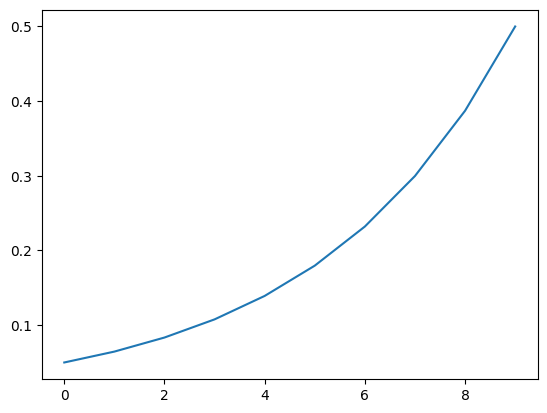

In [37]:
import numpy as np

skew_max = 0.5
num_samples = 10

# Linear space of skew values
skew_values = np.linspace(0, skew_max, num_samples)

# Quadratic space of skew values
skew_values = np.linspace(0, skew_max ** 2, num_samples) ** 0.5


# Exponentially increasing space of skew values
def exponentially_increasing(start, peak, steps):
    # Calculate the start and end values in log space
    log_start = np.log10(start)
    log_peak = np.log10(peak)
    return np.logspace(log_start, log_peak, steps)

skew_values = exponentially_increasing(0.05, 0.5, num_samples)

# plot the skew values
import matplotlib.pyplot as plt
plt.plot(skew_values)

In [19]:
skew_values

array([0.05      , 0.05117655, 0.05238079, 0.05361336, 0.05487494,
       0.0561662 , 0.05748785, 0.0588406 , 0.06022518, 0.06164234,
       0.06309284, 0.06457748, 0.06609706, 0.06765239, 0.06924432,
       0.07087371, 0.07254144, 0.07424841, 0.07599555, 0.07778381,
       0.07961414, 0.08148754, 0.08340503, 0.08536763, 0.08737642,
       0.08943248, 0.09153691, 0.09369087, 0.09589551, 0.09815203,
       0.10046165, 0.10282562, 0.10524521, 0.10772173, 0.11025654,
       0.11285099, 0.11550649, 0.11822447, 0.12100641, 0.12385382,
       0.12676822, 0.12975121, 0.13280439, 0.13592941, 0.13912797,
       0.14240179, 0.14575265, 0.14918236, 0.15269278, 0.15628579,
       0.15996336, 0.16372746, 0.16758013, 0.17152346, 0.17555959,
       0.17969068, 0.18391899, 0.18824679, 0.19267643, 0.1972103 ,
       0.20185086, 0.20660062, 0.21146214, 0.21643806, 0.22153107,
       0.22674393, 0.23207944, 0.23754051, 0.24313008, 0.24885118,
       0.2547069 , 0.26070041, 0.26683496, 0.27311386, 0.27954

In [24]:
import numpy as np

def get_exponential_value(start, peak, steps, x):
    # Calculate the base of the exponential function
    b = (peak / start) ** (1 / (steps - 1))
    # Calculate the value at position x
    y = start * (b ** x)
    return y

# Example usage:
start_value = 0.05
peak_value = 0.5
steps = 10_000_000
x = 25  # Position to look up

y_value = get_exponential_value(start_value, peak_value, steps, x)
print(f'The value at step {x} is {y_value}')

The value at step 25 is 0.0894324764528716


In [34]:
min_skew = 0.05
max_skew = 0.5
num_samples = 10_000_000

skew_value_eq = (max_skew / min_skew) ** (1 / (num_samples - 1))

def get_skew_values(x):
    return min_skew * (skew_value_eq ** x)


get_skew_values(np.array([0, 100, 2_000, 30_000, 400_000, 1_000_000, 9_999_999], dtype=np.float32))

array([0.05      , 0.05000119, 0.05002385, 0.05035891, 0.05500315,
       0.06346202, 0.5425109 ], dtype=float32)

In [1]:
import numpy as np
import pandas as pd

sid_to_sw = pd.read_csv("sample_id_to_sample_weights.csv", index_col=0)
sid_to_sw = sid_to_sw.to_dict()["sample_weight"]

In [ ]:
np.min(list(sid_to_sw.values()))

0.024394170768953